# Trabajo Práctico 1

In [140]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from pathlib import Path

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

## 1. Entrene una red de Hopfield ‘82 con un conjunto de imágenes binarias.

Se encuentran 2 tamaños distintos en las imágenes de prueba, por lo que se las subdivide en 2 grupos:

In [155]:
ImageNames45x60=[
  "images/paloma.bmp",
  "images/quijote.bmp",
  "images/torero.bmp",
];

ImageNames50x50=[  
  "images/panda.bmp",
  "images/perro.bmp", 
  "images/guyFawkes.bmp"
]

1) De tamaño 45x60

In [156]:
def PlotFiles(fileNames):
    f, subplots = plt.subplots(1, 3)
    for path,splt in zip( fileNames, subplots):
        splt.imshow(plt.imread(path))
        splt.set_title(Path(path).with_suffix("").name)
        splt.axis('off')

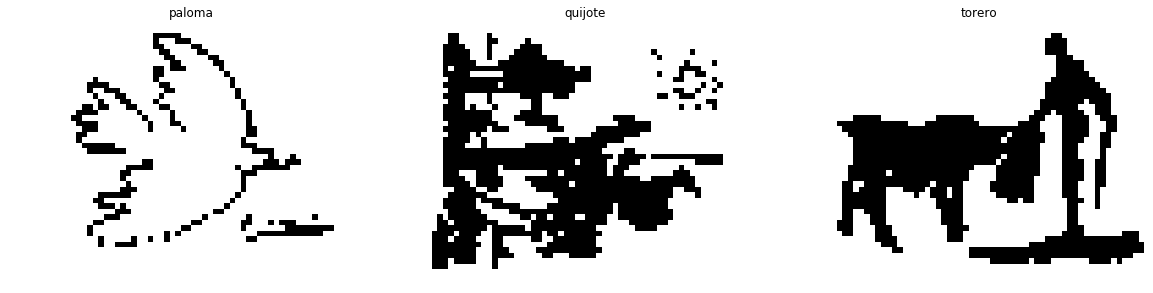

In [157]:
PlotFiles(ImageNames45x60)

2) De tamaño 50x50

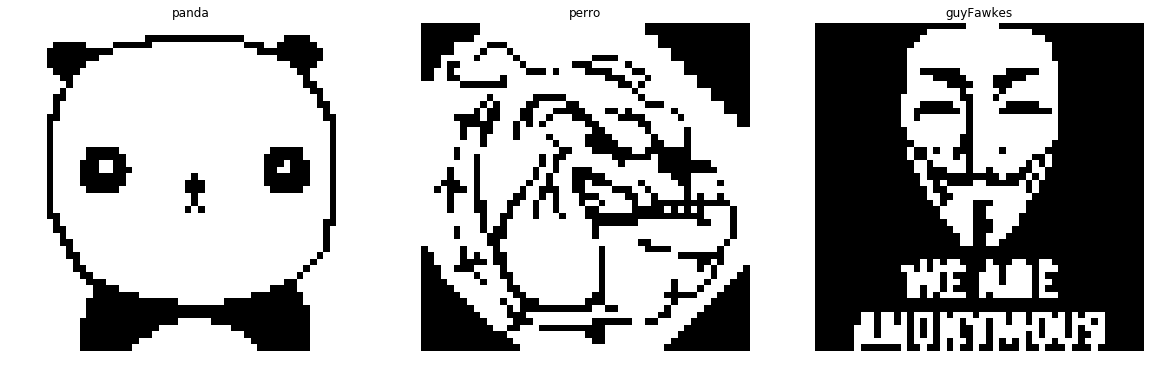

In [158]:
PlotFiles(ImageNames50x50)

In [159]:
# Definición de funciones auxiliares:

In [160]:
def signo(val):
  return (val >= 0)*2-1

In [9]:
def LoadImages(image_file_names):
    #Carga de las Imagenes  
    return [ (plt.imread(file_name)[:,:,0] / 255 * 2 -1 ).reshape(-1,1) for file_name in image_file_names]
    #return np.squeeze( [ (plt.imread(file_name)[:,:,0] / 255 * 2 -1 ).reshape(-1,1) for file_name in image_file_names], axis=2 )

In [10]:
def PlotImage(pobj,imgArray):
    pobj.imshow(( imgArray >= 0 ).astype("double"),cmap='gray')
    #pobj.axis('off')
    pobj.xaxis.set_ticks([])
    pobj.yaxis.set_ticks([])
    pobj.spines['top'].set_visible(False)
    pobj.spines['right'].set_visible(False)
    pobj.spines['bottom'].set_visible(False)
    pobj.spines['left'].set_visible(False)

El entrenamientod e hopfield consiste en armar una matriz de pesos sinápticos.

Para los subconjuntos de imágenes se calcula la matriz de pesos como:

$W = \sum_{i=1}^N Z_i \cdot Z_i^T - N * I$

Donde N es la cantidad de patrones, $Z_i$ es un vector de tamaño K con el i-ésimo patrón a aprender y I es la matriz identidad tamaño $k \times k$

In [11]:
def CalculateWeights(Images):
    return np.sum( [ img.dot(img.transpose())-np.eye(len(img)) for img in Images ] , 0 )

Sea una entrada $S$ de dimensión $k$, el algoritmo de hopfield consiste de:


1) Seleccionar aleatoriamente un elemento $\sigma_j$ de $S$

In [8]:
def hopfield(seed,w,N,M):
    outVal = np.copy(seed);
    iteration = 1;
    changed = True;
    while(changed):
        changed = False;
        for i in np.random.permutation(len(outVal)):
            hi=signo(w[i,:].reshape(1,-1).dot(outVal))
            changed |= (hi != outVal[i])
            outVal[i]=hi
    #PlotImage(plt.gca(),outVal.reshape(N,M))
    return outVal

In [12]:
def AutoTest(SourceImages, TargetImages, W,N,M):
    #chequeo si aprendio evaluando las mismas imagenes.
    return [ np.all(hopfield(src,W,N,M) == tgt) for src,tgt in zip(SourceImages, TargetImages)]

### a) Verifique si la red aprendió las imágenes enseñadas.

In [13]:
def DoesLearn(ImageNames,h,w):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    Learned=AutoTest(Images,Images,W,h,w)
    #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip(ImageNames, Learned)],columns=["Image","Learned"]).set_index(["Image",])

In [14]:
DoesLearn(ImageNames45x60,45,60)

,Learned
Image,
images/paloma.bmp,True
images/quijote.bmp,True
images/torero.bmp,True


In [15]:
DoesLearn(ImageNames50x50,50,50)

,Learned
Image,
images/panda.bmp,True
images/perro.bmp,True
images/v.bmp,True


Se verifica que se aprendieron ambos grupos de 3 imágenes.

### b) Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes aprendidas: agregado de ruido, elementos borrados o agregados.

#### Ruido
Se le agrega ruido digital a las imágenes. Invirtiendo cada pixel de la imágen con una probabilidad *p*

In [14]:
def AddNoise(image,level):
    return image * (( np.random.rand(* image.shape) > level ).astype(np.int32) * 2 - 1);

In [15]:
def TestNoise(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
            
    levels=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]    
    #f, subplots = plt.subplots(len(levels), len(ImageNames))
    
    df = pd.DataFrame(columns=["Image"]+levels)
    df["Image"]=ImageNames
    
    #for lvl,pltRow in zip(levels,subplots):
    for lvl in levels:
        ImagesWithNoise = [ AddNoise(image,lvl) for image in Images ]
        f, pltRow = plt.subplots(1, len(ImageNames))
        
        for image,pltobj in zip(ImagesWithNoise,pltRow):
            PlotImage(pltobj,image.reshape(N,M))
        pltRow[0].set_ylabel("p=%.2g" % lvl)
        
        
        df[lvl] = AutoTest(ImagesWithNoise,Images,W,N,M)
        
    
    return df.set_index(["Image",])

,0.01,0.05,0.1,0.2,0.3,0.4,0.5
Image,,,,,,,
images/paloma.bmp,True,True,True,True,True,True,False
images/quijote.bmp,True,True,True,True,True,True,False
images/torero.bmp,True,True,True,True,True,True,False


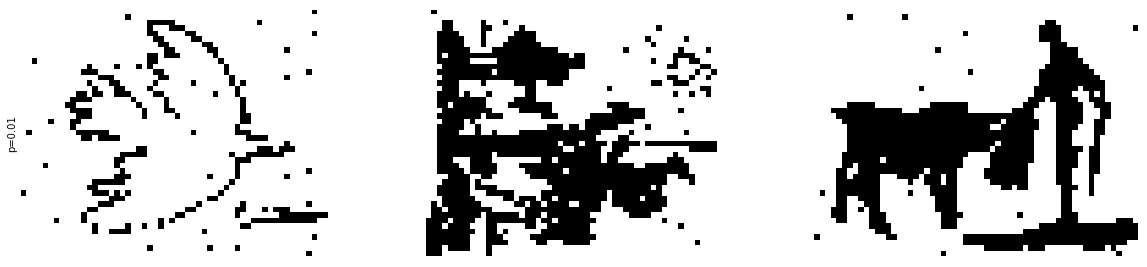

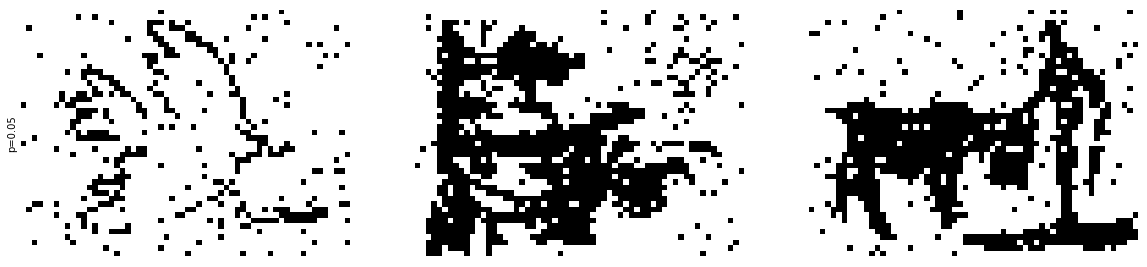

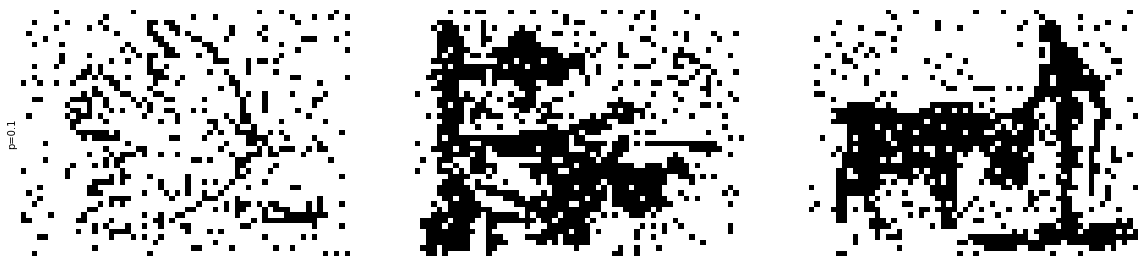

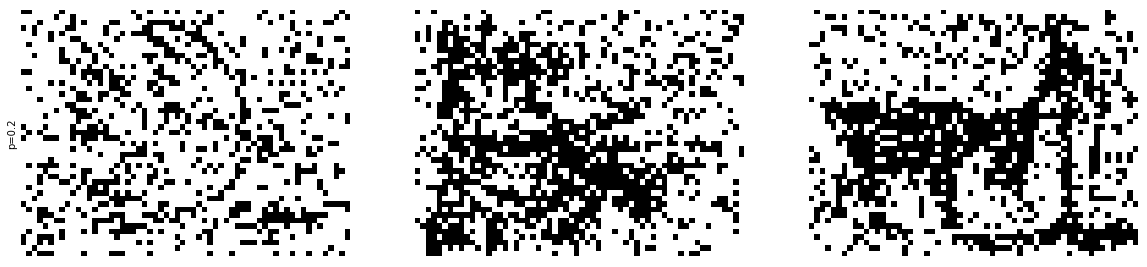

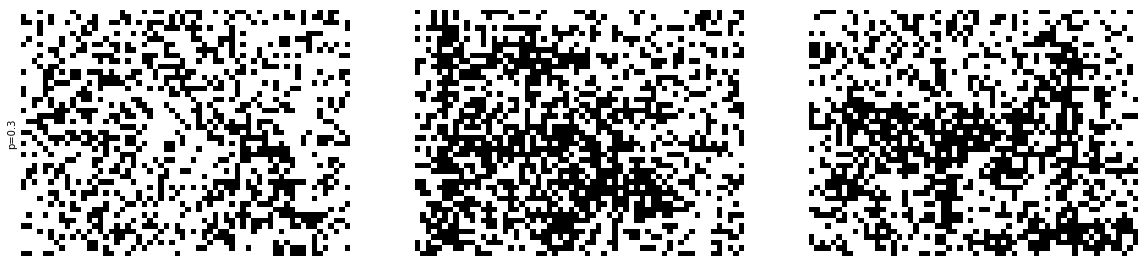

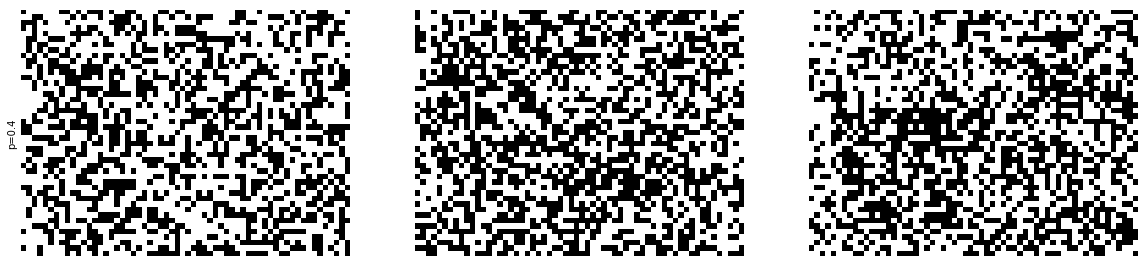

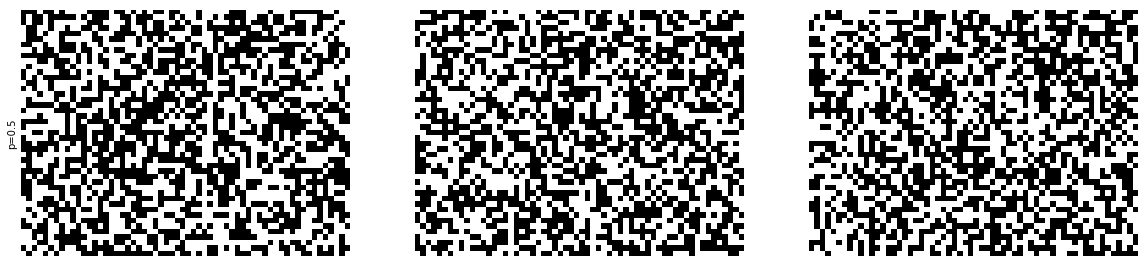

In [18]:
TestNoise(ImageNames45x60,45,60)

,0.01,0.05,0.1,0.2,0.3,0.4,0.5
Image,,,,,,,
images/panda.bmp,True,True,True,True,True,True,False
images/perro.bmp,True,True,True,True,True,True,False
images/v.bmp,True,True,True,True,True,True,False


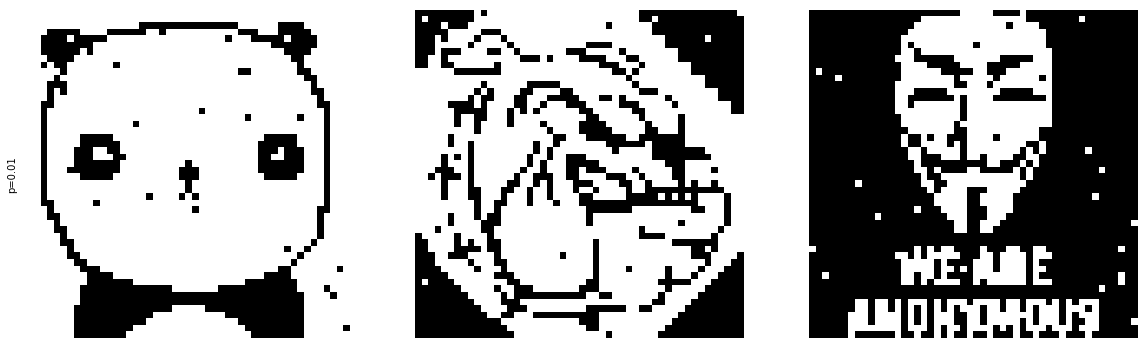

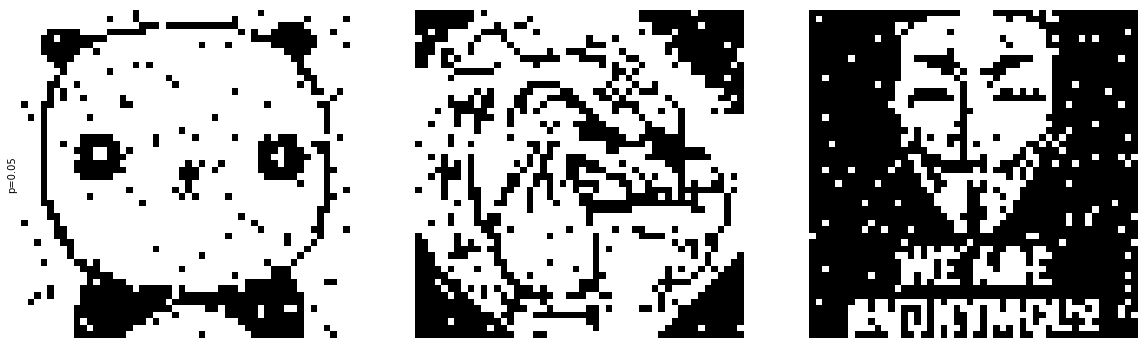

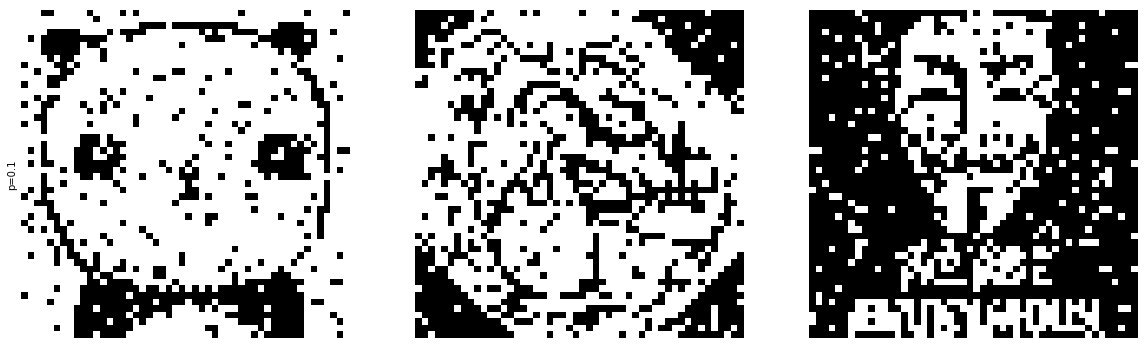

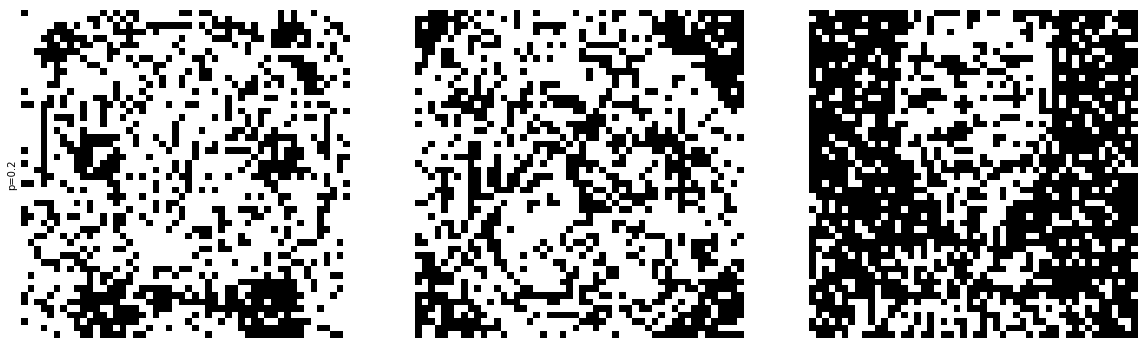

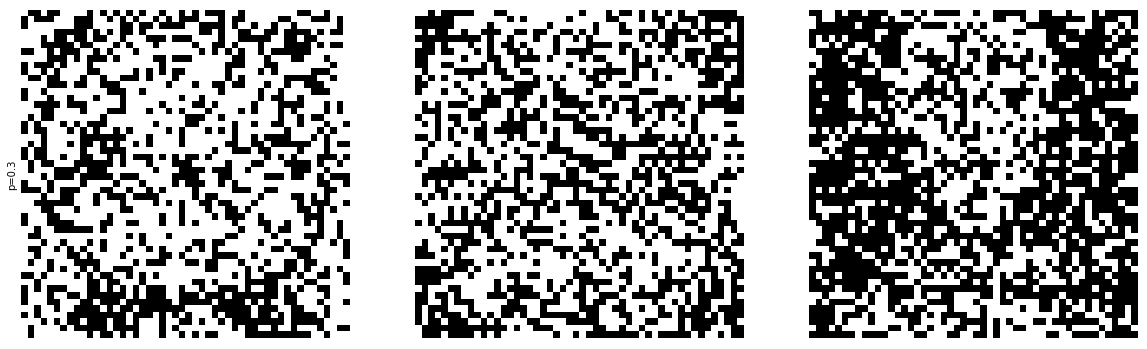

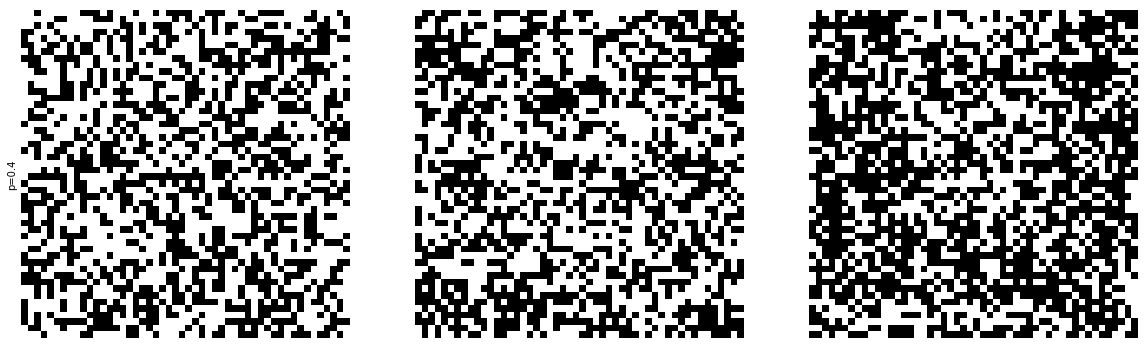

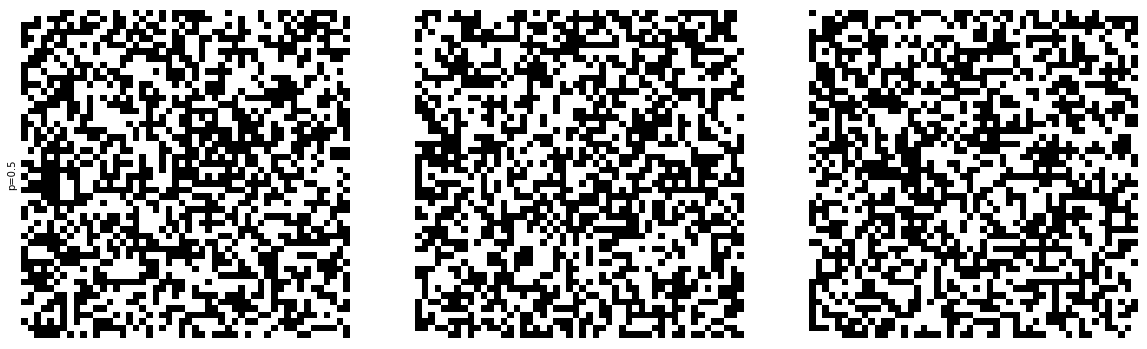

In [19]:
TestNoise(ImageNames50x50,50,50)

Repetidos ensayos mostraron que para 3 imágenes el algoritmo es robusto a ruido digital hasta p=0.4. Con p=0.5 el algoritmo converje a la imagen equivocada más frecuentemente de lo que acierta. Para p > 0.5 el atractor cambia a la imágen inversa.

#### Máscaras

Se ensayaron máscaras rectangulares que cubren distintos porcentajes de las imágenes de prueba, y se las usó como entrada en el algoritmpo de Hopfield.

In [16]:
def CreateMask(N,M,lvl):
    mask=np.zeros([N,M])
    mask[0:int(np.floor(N*lvl)),0:int(np.floor(M*lvl))]=1
    return mask

In [17]:
def MaskImages(Images,N,M,lvl):
    mask=CreateMask(N,M,lvl).reshape(-1,1)
    return [ ((image + mask) >= 0 ).astype(np.int32) * 2 - 1 for image in Images  ]

In [18]:
def TestMasked(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    levels = np.arange(0.2,0.8,0.2)
    
    df = pd.DataFrame(columns=["Image"]+list(levels))
    df["Image"]=ImageNames
    
    for lvl in levels:
        MaskedImages = MaskImages(Images,N,M,lvl)
        
        f, pltRow = plt.subplots(1, len(ImageNames))
        for image,pltobj in zip(MaskedImages,pltRow):
            PlotImage(pltobj,image.reshape(N,M))
        pltRow[0].set_ylabel("masked=%.2g" % lvl)
        
        df[lvl] = AutoTest(MaskedImages,Images,W,N,M)
        
    return df.set_index(["Image",])

,0.2,0.4,0.6000000000000001,0.8
Image,,,,
images/paloma.bmp,True,True,True,True
images/quijote.bmp,True,True,False,False
images/torero.bmp,True,True,True,False


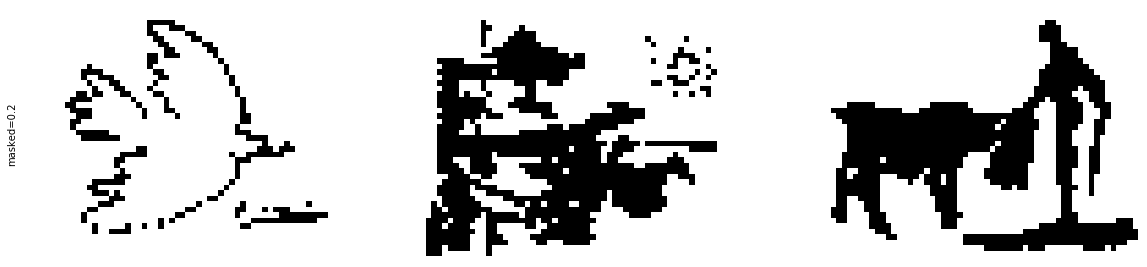

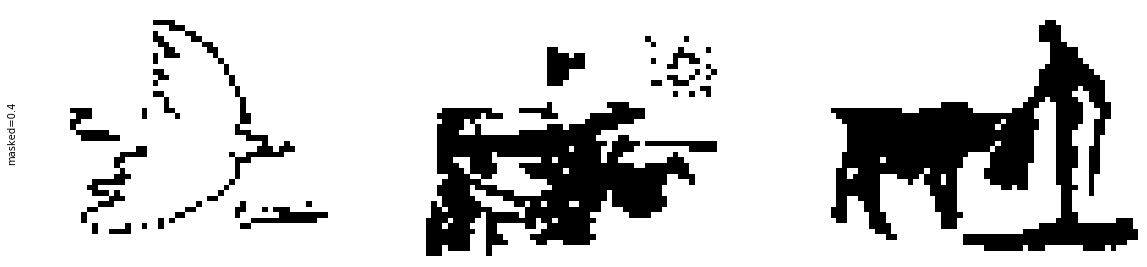

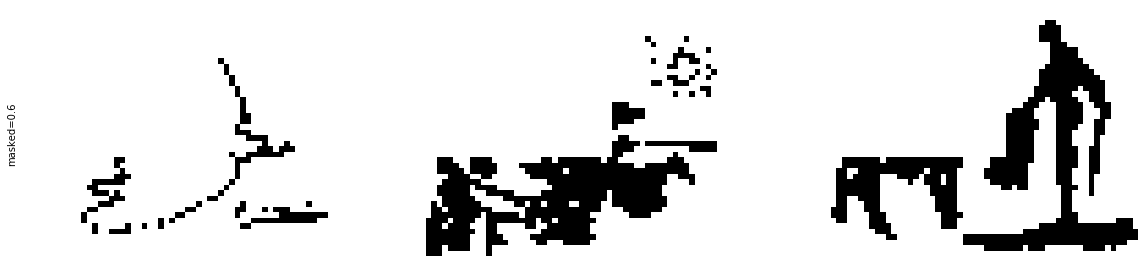

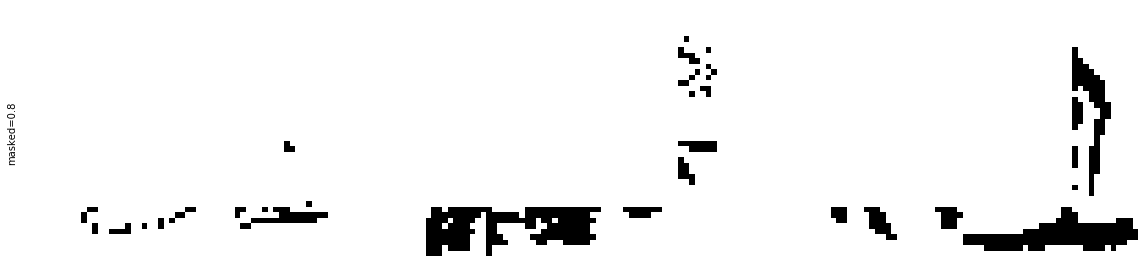

In [23]:
TestMasked(ImageNames45x60,45,60)

,0.2,0.4,0.6000000000000001,0.8
Image,,,,
images/panda.bmp,True,True,True,True
images/perro.bmp,True,True,True,True
images/v.bmp,True,True,True,False


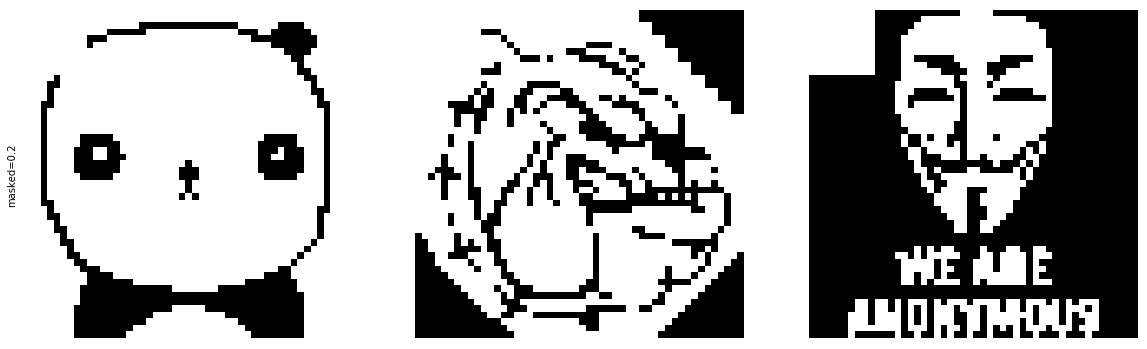

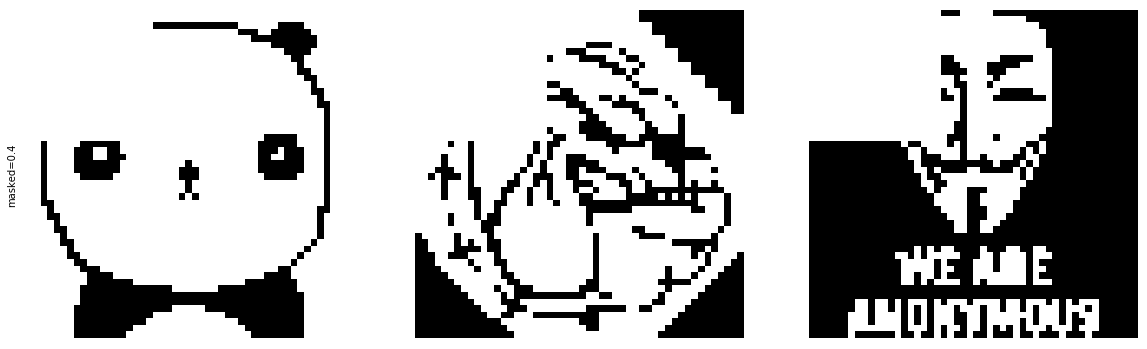

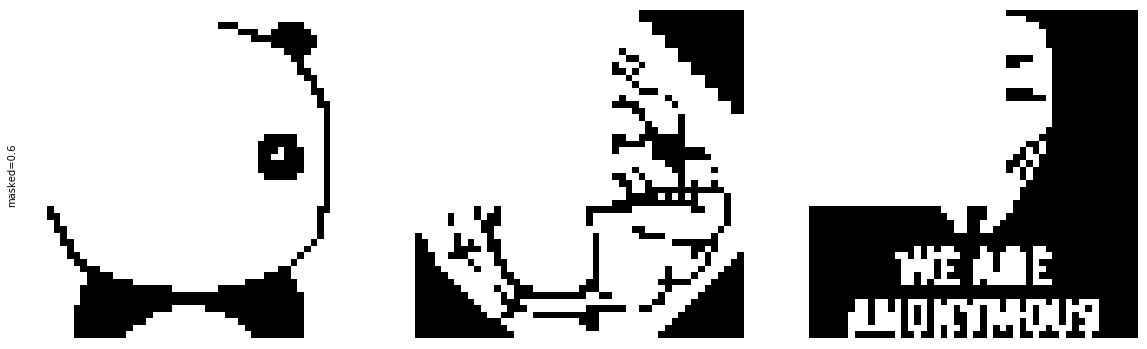

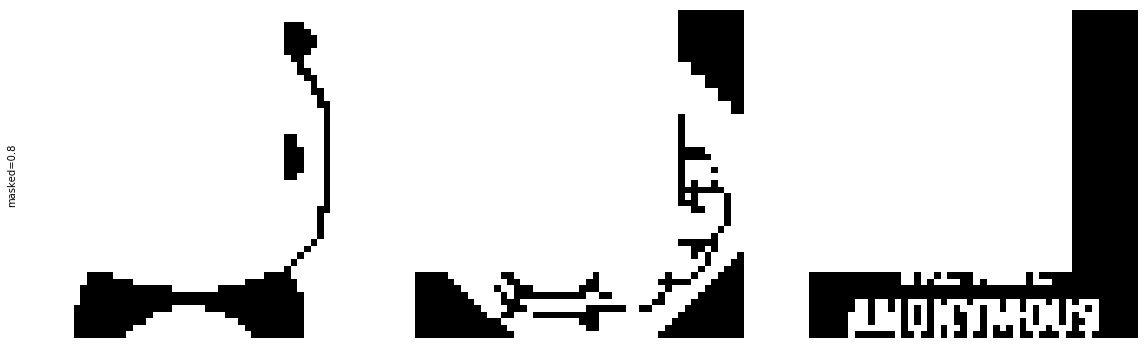

In [24]:
TestMasked(ImageNames50x50,50,50)

Se observa que el algoritmo tolera máscaras que cubren hasta el 60% de la imágen, pero cuando cubre el 80% algunas imágenes comienzan a fallar.

### c) Evalúe la existencia de estados espurios en la red: patrones inversos y combinaciones de un número impar de patrones. *(Ver Spurious States, en la sección 2.2, Hertz, Krogh & Palmer, pág. 24)*.

Validación de los poatrones negativos:

In [19]:
def DoesLearnNegative(ImageNames,h,w):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    negatives=[ -1*image for image in Images]
    
    f, pltRow = plt.subplots(1, len(ImageNames))
    for image,pltobj in zip(negatives,pltRow):
        PlotImage(pltobj,image.reshape(h,w))
        
    Learned=AutoTest(negatives ,negatives,W,h,w)
    #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip(ImageNames, Learned)],columns=["Image","Learned"]).set_index(["Image",])

,Learned
Image,
images/paloma.bmp,True
images/quijote.bmp,True
images/torero.bmp,True


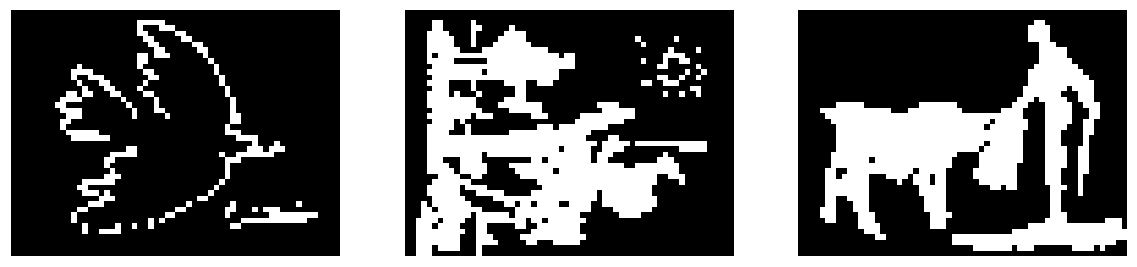

In [26]:
DoesLearnNegative(ImageNames45x60,45,60)

,Learned
Image,
images/panda.bmp,True
images/perro.bmp,True
images/v.bmp,True


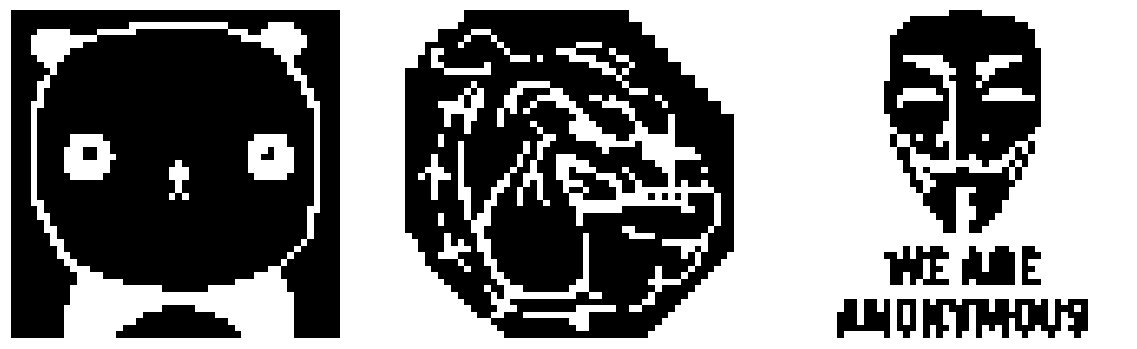

In [27]:
DoesLearnNegative(ImageNames50x50,50,50)

Los patrones negativos fueron aprendidios correctamente. Validado esto, se arma un conjunto de patrones expandido con los patrones positivos y negativos y se evaluan todas las combianaciones suma de 3 elementos de este conjunto.

Esto volverá a evaluar los patrones positivos y negativos, ya que si se suman 3 patrones A + B + C, donde A = -B, A y B se cancelan y queda el patrón C.

In [20]:
def PlotImages(Images,N,M, columns):
    i = 0
    for Image in Images:
        if i == 0:
            f, pltRow = plt.subplots(1, columns)
        PlotImage(pltRow[i],Image.reshape(N,M))
        i+=1
        if i == columns:
            i=0
        
    while ( i > 0 and columns > i ):
        f.delaxes(pltRow[i])
        i+=1

In [21]:
def GenerateOddSpurious(Images):
    ExtendedImages = np.squeeze( Images + [-1 * image for image in Images], axis=2)
    combs = list(itertools.combinations(range(len(ExtendedImages)),3))
    return [ (ExtendedImages[list(comb)].sum(axis=0) >= 0).astype(np.int32) * 2 - 1 for comb in combs ]
    

In [22]:
def TestSpurious(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    SpuriousImages=GenerateOddSpurious(Images)
    
    Learned=AutoTest(SpuriousImages ,SpuriousImages,W,N,M)
    PlotImages( np.unique(SpuriousImages,axis=0), N,M, 4 )
    
    combs = ["".join(comb) for comb in itertools.combinations(["A","B","C","-A","-B","-C"],3)]
        #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip(combs, Learned)],columns=["Comb","Learned"]).set_index(["Comb",]).transpose()

Comb,ABC,AB-A,AB-B,AB-C,AC-A,AC-B,AC-C,A-A-B,A-A-C,A-B-C,BC-A,BC-B,BC-C,B-A-B,B-A-C,B-B-C,C-A-B,C-A-C,C-B-C,-A-B-C
Learned,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


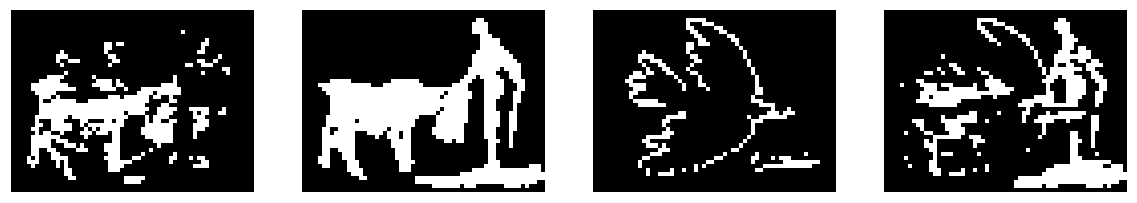

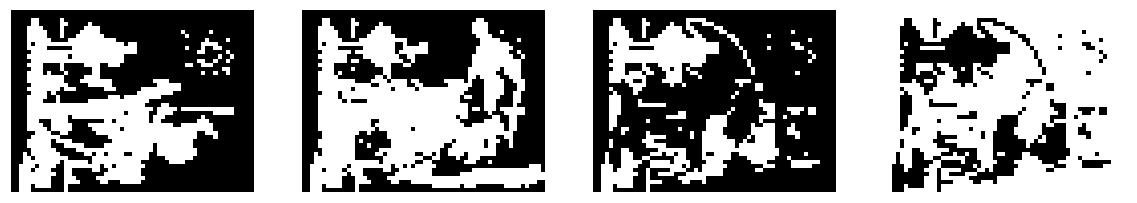

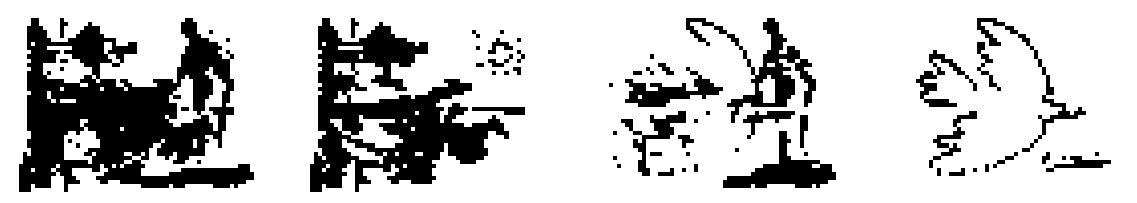

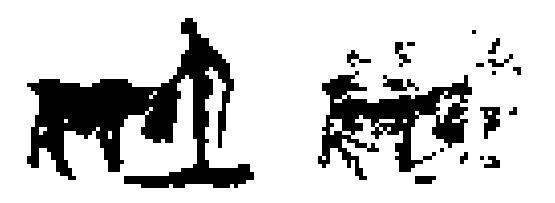

In [31]:
TestSpurious(ImageNames45x60,45,60)

Comb,ABC,AB-A,AB-B,AB-C,AC-A,AC-B,AC-C,A-A-B,A-A-C,A-B-C,BC-A,BC-B,BC-C,B-A-B,B-A-C,B-B-C,C-A-B,C-A-C,C-B-C,-A-B-C
Learned,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


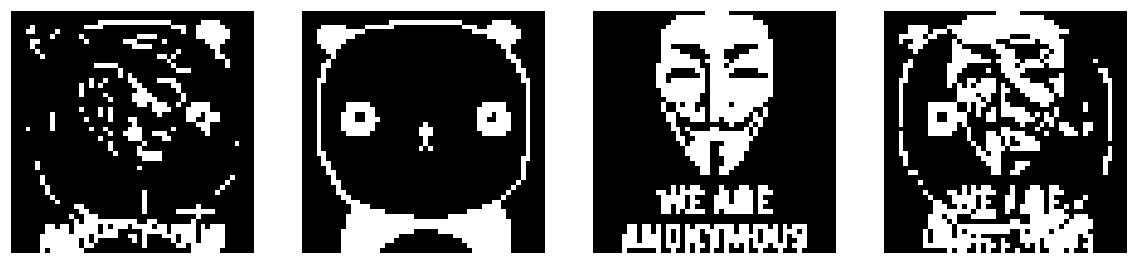

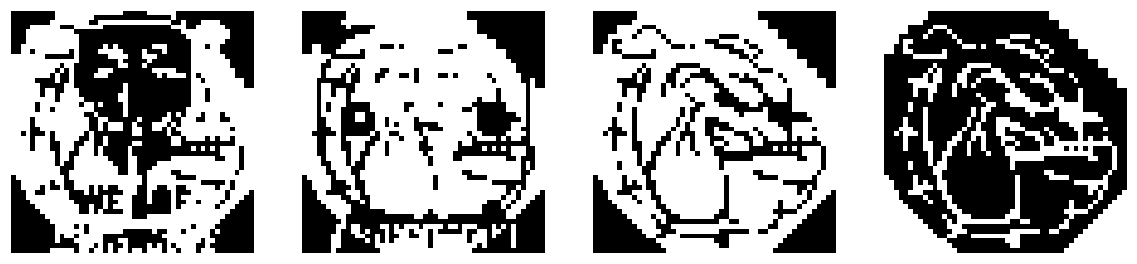

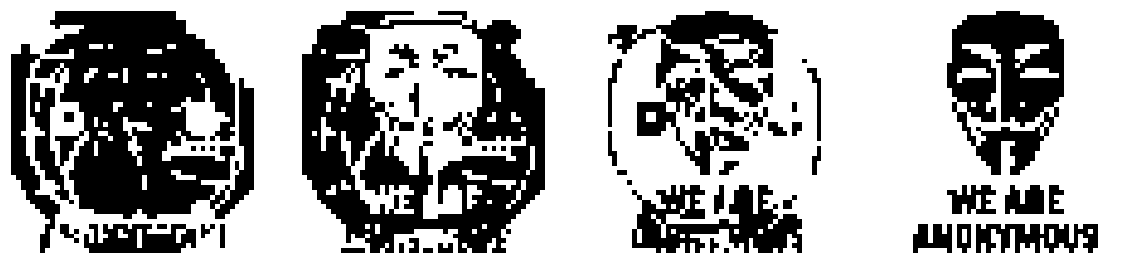

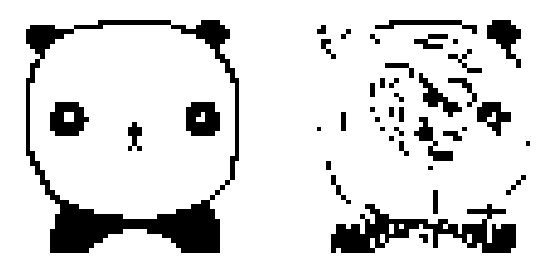

In [32]:
TestSpurious(ImageNames50x50,50,50)

Todos los patrones generados como suma de 3 patrones resulta en un patrón aprendido por la red para ambos conjuntos de imágenes.

### d) Realice un entrenamiento con todas las imágenes disponibles. ¿Es capaz la red de aprender todas las imágenes? Explique.

Para poder cargar todas las imágenes juntas es necesario primero homogeneizar el tamaño. Para ello se eligió extender las imágenes con un padding.o

In [23]:
def LoadImagesWithPadding(ImageFileNames,N,M,paddingFunction):
    for image_name in ImageFileNames:
        base_image=(plt.imread(image_name)[:,:,0] / 255 ).astype(np.double) * 2 - 1
        padded_image=(paddingFunction(N,M) > 0.5).astype(np.int32).astype(np.double) * 2 - 1
        padded_image[:base_image.shape[0],:base_image.shape[1]] = base_image
        yield padded_image.reshape(-1,1)

In [24]:
def DoesLearnWithPadding(ImageNames,h,w,paddingFunction):
    Images=list(LoadImagesWithPadding(ImageNames,h,w,paddingFunction))
    PlotImages(Images,h,w,3)
    W=CalculateWeights(Images)
    Learned=AutoTest(Images,Images,W,h,w)
    #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip(ImageNames, Learned)],columns=["Image","Learned"]).set_index(["Image",])



,Learned
Image,
images/paloma.bmp,False
images/quijote.bmp,True
images/torero.bmp,False
images/panda.bmp,True
images/perro.bmp,True
images/v.bmp,True


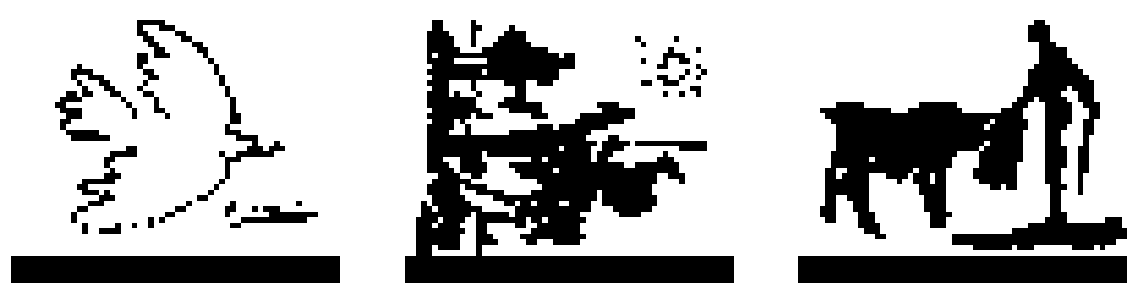

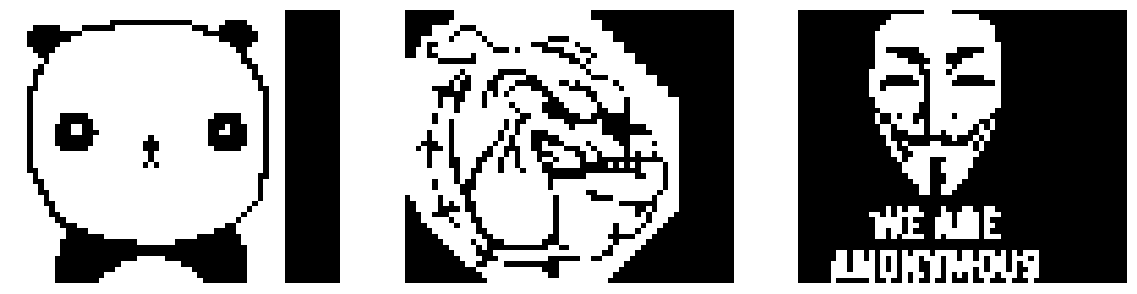

In [35]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.zeros([h,w]))

,Learned
Image,
images/paloma.bmp,False
images/quijote.bmp,False
images/torero.bmp,False
images/panda.bmp,False
images/perro.bmp,False
images/v.bmp,True


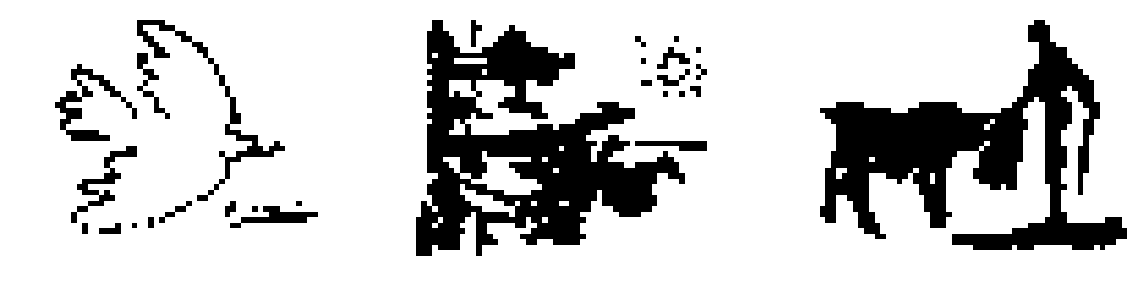

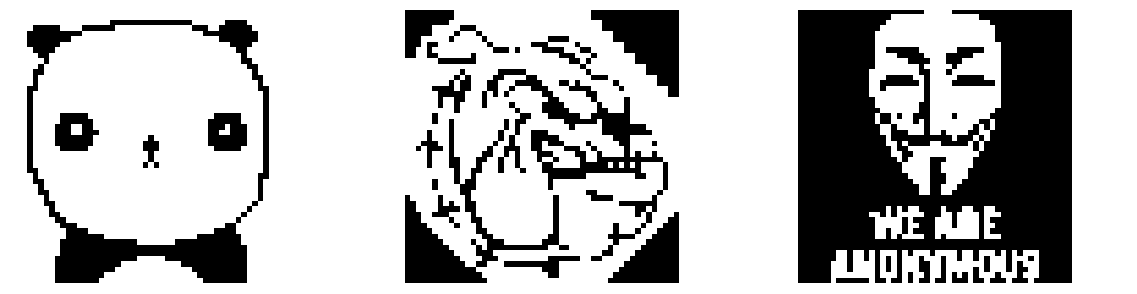

In [36]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.ones([h,w]))

,Learned
Image,
images/paloma.bmp,False
images/quijote.bmp,True
images/torero.bmp,True
images/panda.bmp,True
images/perro.bmp,True
images/v.bmp,True


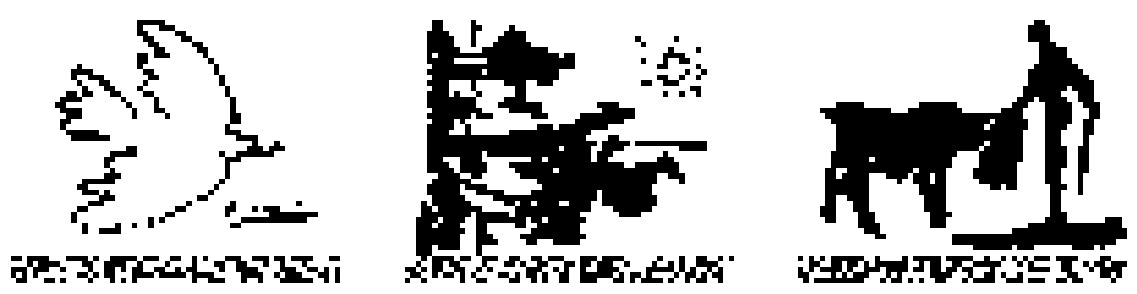

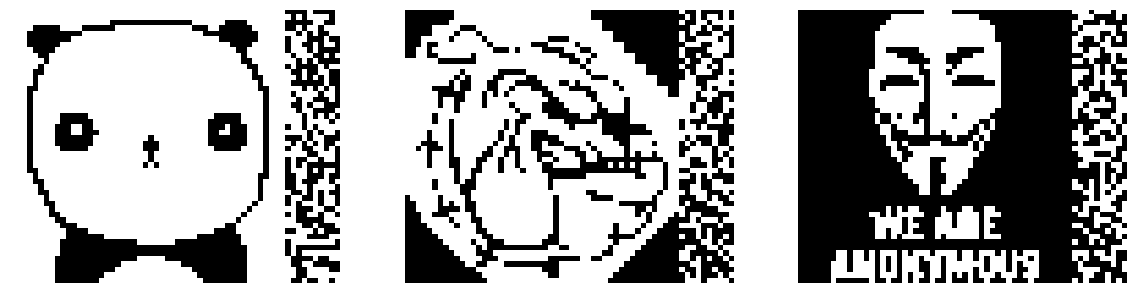

In [37]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,np.random.rand)

En ninguno de los casos la red pudo aprender todos los patrones, pero los resultados variaron con el tipo de padding utilizado.
El padding el blanco fue el que produjo mayores solapamientos y solo aprendio un patrón.
El padding en negro produjo que 2 patrones no pudieran ser aprendidos.
El padding con patrones pseudoaleatorios produje que 1 o 2 patrones nos e pudieran aprender dependiendo de la corrida.

In [25]:
def ConvergingPatterns(ImageNames,h,w,paddingFunction):
    Images=list(LoadImagesWithPadding(ImageNames,h,w,paddingFunction))
    W=CalculateWeights(Images)
    PlotImages([hopfield(image,W,h,w) for image in Images],h,w,3)

Patrones a los que converje el algoritmo:

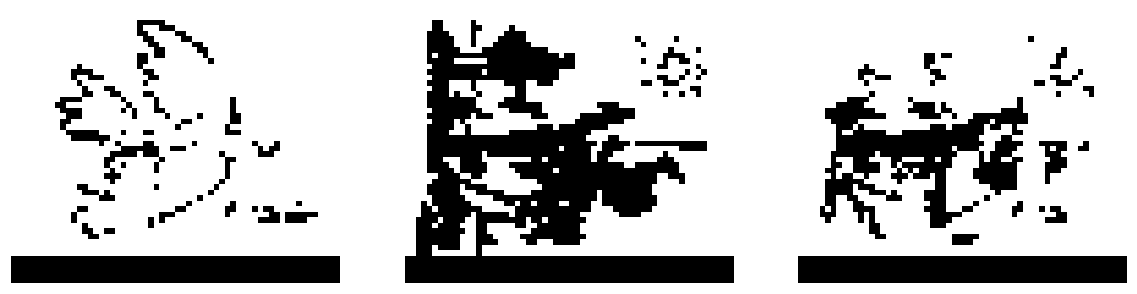

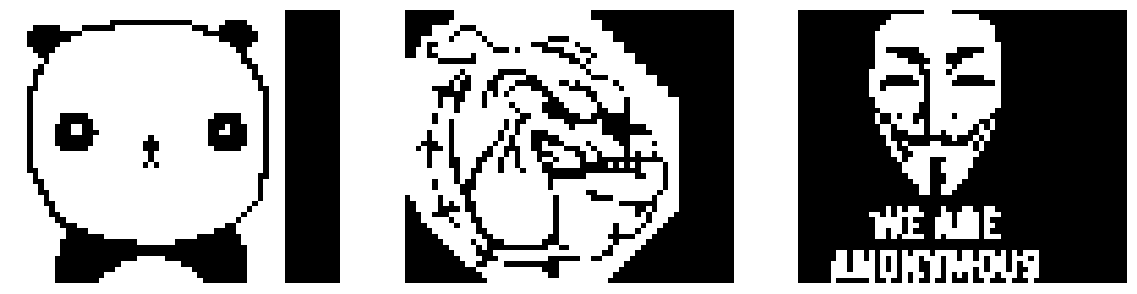

In [26]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.zeros([h,w]))

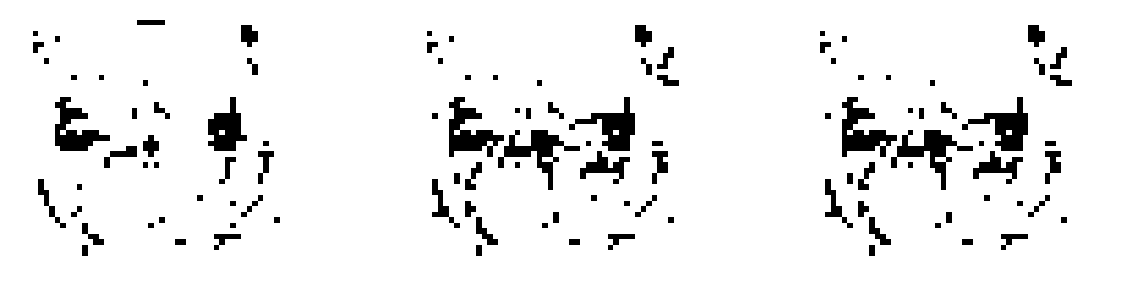

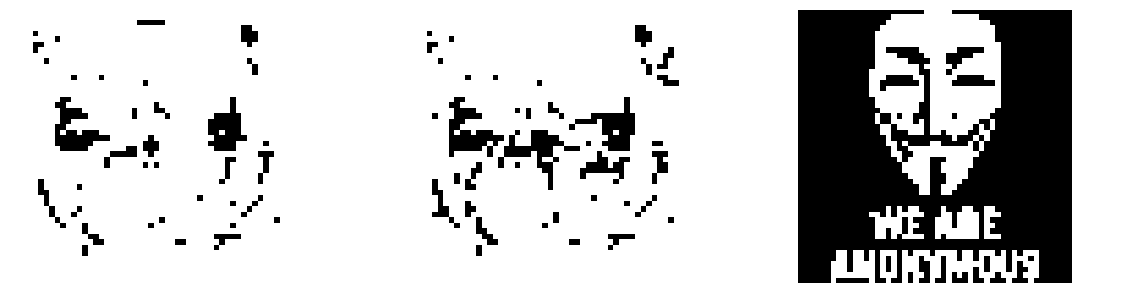

In [40]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.ones([h,w]))

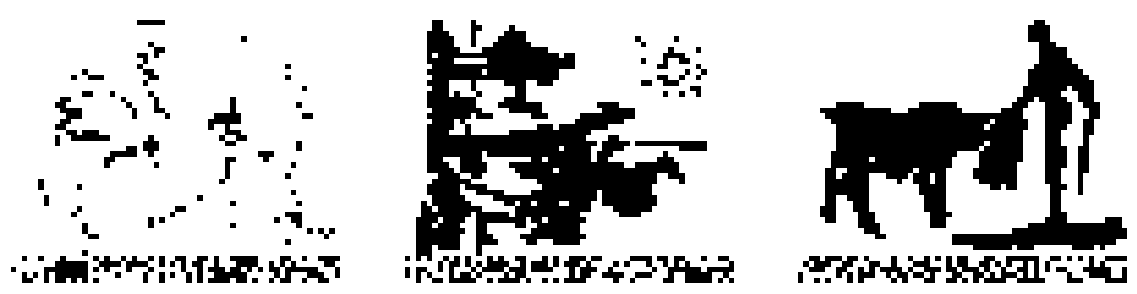

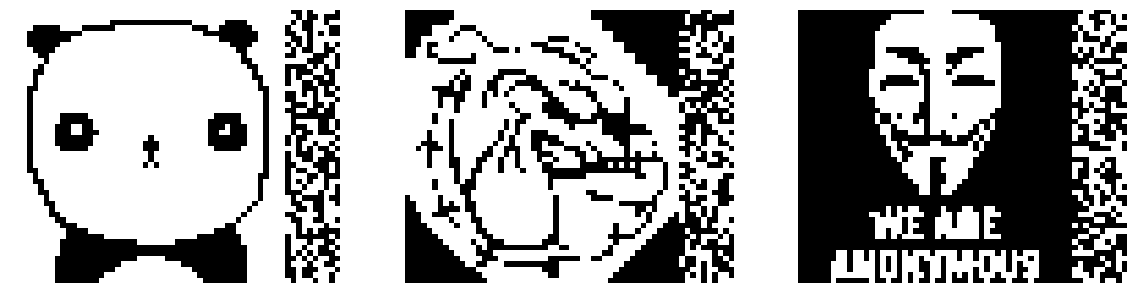

In [41]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,np.random.rand)

Observando a dónde convergen los patrones que fallaron, se observa que los patrones de salida contienen parte de la información del patrón de entrada por ejemplo las alas de la paloma y las patas del toro todavía pueden apreciarse para el caso del padding negro.

Se concluye que los patrones no son lo suficientemente ortogonales entre sí para ser aprendidos todos.

## 2. Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño de la red.

###  a) Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteración con actualización sincrónica).

In [27]:
tableHertzEtAl=pd.DataFrame([
    [0.001, 0.105],
    [0.0035, 0.138],
    [0.01,0.185],
    [0.05,0.37],
    [0.1,0.61]],columns=["Perror","pmax/N"]).set_index("Perror")

In [28]:
def randImageGen(N,P):
    return [ (np.random.rand(N,1) > 0.5).astype(np.int32).astype(np.double) * 2 - 1  for _ in range(P)]

In [29]:
def calcPError(algo,imageGen,N,P):
    Images=imageGen(N,P)
    W=CalculateWeights(Images)
    return np.sum([(algo(image,W,N,1) != image ).astype(np.int32).sum()/N for image in Images ])/P

In [30]:
class ExceededMaxIterations(Exception):
    pass

In [31]:
def repeatPError(algo,imageGen,N,P):
    step=10
    acc=[]
    while(True):
        try:
            #Exception Shuld 
            acc+=[ calcPError(algo,imageGen,N,P) for _ in range(10) ]
        except ExceededMaxIterations as e:
            print(str(e))
            continue
         
        std = np.std(acc,ddof=1)
        if 1.96*std/np.sqrt(len(acc)) < 0.001: #2.32
            print(N,P,N/P,end='\r')
            break            
    return np.mean(acc)

In [32]:
def FillTable(algo, span ):
    df=pd.DataFrame(columns=["N","P","PError"]).set_index(["N","P"])

    for N in span:
        pError=0
        P=0
        while pError < 0.1:
            P+=1
            pError = repeatPError(algo,randImageGen,N,P)
            df.loc[(N,P),"PError"]=pError
            #print(N,P,pError),
    return df
    

In [33]:
def PlotCapacity(df, tableHertzEtAl):
    for N, new_df in df.groupby(level=0):
        ndf=new_df.reset_index()
        plt.plot(ndf["P"]/ndf["N"],ndf["PError"],label=N)


    ndf=tableHertzEtAl.reset_index()
    plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)
    plt.legend()

Capacidad de la red para Hopfield Asíncrono:

In [34]:
#asyncCapacity=FillTable(hopfield, np.arange(10,30,10))
#asyncCapacity.transpose()

In [35]:
#PlotCapacity(asyncCapacity,tableHertzEtAl)

In [36]:
def syncHopfield(seed,w,N,M,steps):
    outVal = np.copy(seed);
    #iteration = 1;
    changed = True;
    guard=steps
    newVal = np.zeros(outVal.shape);
    while(changed):
        guard-=1
        changed = False;
        for i in range(len(outVal)):
            hi=signo(w[i,:].reshape(1,-1).dot(outVal))
            changed |= (hi != outVal[i])
            newVal[i]=hi
        outVal=newVal
        
        if guard == 0:
            break
            #raise ExceededMaxIterations("Exceeded iterations range: N=%i, M=%i" % [M ,N])
            
    return outVal

In [37]:
def cleanLastPrintedLine():
    print(" " * 80, end='\r')

Capacidad de la red para Hopfield Síncrono:

In [53]:
syncCapacity=FillTable(lambda a,b,c,d: syncHopfield(a,b,c,d,1), np.arange(10,70,10))
cleanLastPrintedLine()
syncCapacity.transpose()

N        10                                                        20       \
P        1    2       3         4         5         6         7    1    2    
PError  0.0  0.0  0.0148  0.043089  0.065392  0.092117  0.110394  0.0  0.0   

N                   ...           60                                          \
P             3     ...           28        29        30        31        32   
PError  0.001026    ...     0.069757  0.073401  0.076926  0.080218  0.083652   

N                                                        
P             33        34       35        36        37  
PError  0.086612  0.091326  0.09391  0.097149  0.100678  

[1 rows x 132 columns]

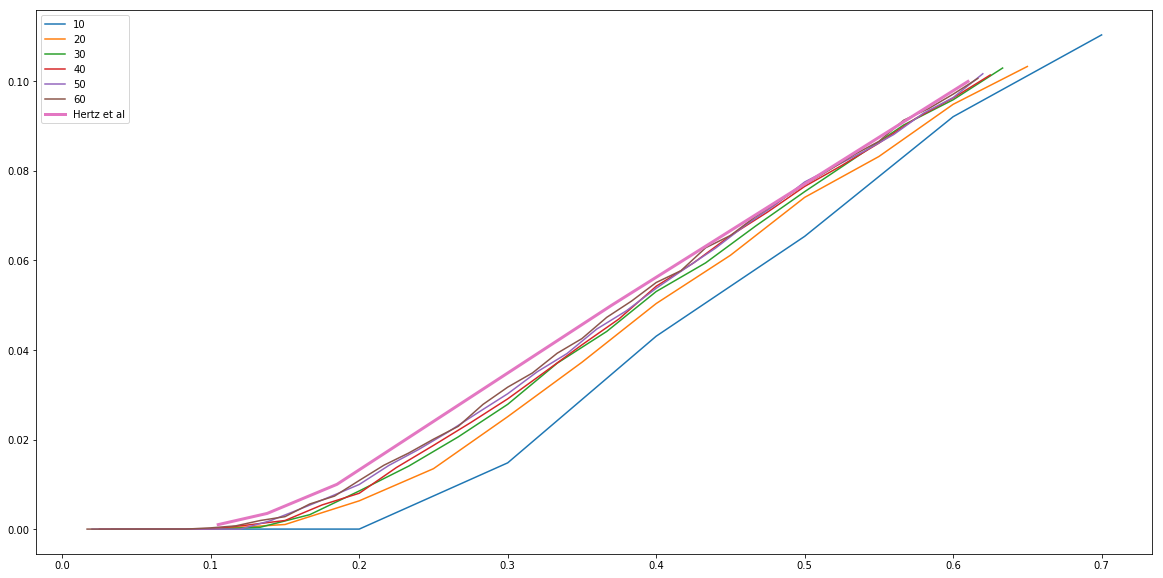

In [54]:
PlotCapacity(syncCapacity,tableHertzEtAl)

Se calculó la probabilidad de error con 3 decimales para un intervalo de confianza del 95%
Si bien no se pudo reproducir la exactamente, se observa que las curvas se acercan a los valores de la tabla de Hertz conforme se incrementa la cantidad de neuronas N.

### b) Analice cómo cambia la capacidad de una red en función de la correlación entre patrones

Si definimos nuestra correlación como:

$\rho = \mathbb{E} \frac{\sum_{j} \xi_{j}^{\mu}\xi_{j}^{\nu}}{N}$

Si N es la cantidad de neuronas, las imágenes se correlacionaron de la siguiente manera:

- La primer imágen ($\nu = 1$)  es pseudo aleatoria
- La $\nu$-ésima imágen con $\nu > 1$ se compone de los valores de $(\nu-1)$ para algún $K < N$ posiciones elegidas al azar. El resto de los posiciónes toma valores aleatorios.


Esto producirá que para 2 patrones consecutivos

$\rho = \mathbb{E} \frac{\sum_{j=1}^{N} \xi_{j}^{\nu}\xi_{j}^{\nu-1}}{N}=\frac{\mathbb{E} \sum_{j=1}^{K} \xi_{j}^{\nu}\xi_{j}^{\nu-1} + \mathbb{E}\sum_{j=K+1}^{N} \xi_{j}^{\nu}\xi_{j}^{\nu-1}}{N} = \frac{K}{N}$

La sumatoria de la derecha corresponde a patrones pseudo-ortogonales por lo que su media es nula.

La sumatoria de la izquierda corresponed a patrones idénticos, por lo que el producto es siempre 1 y la sumatoria vale K

Con éste metodo podemos generar patrones con la correlación deseada.


In [38]:
def genCorrelatedImages(N,P,ro):
    Images=randImageGen(N,P)
    for n in range(1,P):
        rndIdx=np.random.choice(np.arange(N),int(np.floor(N*ro)),replace=False)
        Images[n][rndIdx]=Images[n-1][rndIdx]
    return Images

Se valida que las correlaciones den el resultado correcto, para pares de patrones con N = 10000

In [39]:
def correlationCalculator(ro,N):
    acc=[]
    while(True):   
        acc+=[ (imgs[0]*imgs[1]).sum() for imgs in [ genCorrelatedImages(N,2, ro) for _ in range(1000) ]]

        coor_est = np.mean(acc)/N
        cut_factor = 1.96 * np.std(acc,ddof=1)/np.sqrt(len(acc))
        print(ro,coor_est,cut_factor,end='\r')
        if cut_factor < 0.5:
            cleanLastPrintedLine()
            break
    return coor_est

In [40]:
def evalCorr(N):
    df = pd.DataFrame(columns=["ro","Corr"]).set_index("ro")
    for ro in np.arange(0,1,0.1):
        df.loc[ro,"Corr"]=correlationCalculator(ro,N)    
    return df

In [61]:
evalCorr(10000)

,Corr
ro,
0.0,2.56922e-05
0.1,0.100016
0.2,0.200037
0.3,0.300016
0.4,0.400023
0.5,0.500005
0.6,0.599975
0.7,0.699953
0.8,0.800041


Se testea el generador de patrones correlacionados para N = 10000. Se observa que los patrones se generan con la correlación configurada a la entrada.

Se realiza el cálculo de capacidad para N=30

In [41]:
def corrFillTable(algo, N, span ):
    df=pd.DataFrame(columns=["ro","P","PError"]).set_index(["ro","P"])

    for ro in span:
        pError=0
        P=0
        while pError < 0.1:
            P+=1
            roundRo = np.floor(N*ro)/N
            pError = repeatPError(algo,lambda n,p:genCorrelatedImages(n,p,roundRo),N,P)
            df.loc[(roundRo,P),"PError"]=pError
            #print(N,P,pError),
    return df

In [42]:
def corrPlotCapacity(df,tableHertzEtAl,N):
    for ro, new_df in df.groupby(level=0):
        ndf=new_df.reset_index()
        plt.plot(ndf["P"]/N,ndf["PError"],label=ro)
        
    ndf=tableHertzEtAl.reset_index()
    plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)    
    plt.legend()

In [64]:
corrCapacity=corrFillTable(lambda a,b,c,d: syncHopfield(a,b,c,d,1), 30, np.arange(0,1,0.1))
corrCapacity

PError
ro  P           
0.0 1   0.000000
    2   0.000000
    3   0.000000
    4   0.000417
    5   0.001111
    6   0.007880
    7   0.013971
    8   0.020640
    9   0.028473
    10  0.036935
    11  0.044075
    12  0.052225
    13  0.060455
    14  0.067390
    15  0.075077
    16  0.081405
    17  0.088836
    18  0.095879
    19  0.101740
0.1 1   0.000000
    2   0.000000
    3   0.000000
    4   0.001212
    5   0.004278
    6   0.009787
    7   0.015296
    8   0.022328
    9   0.029851
    10  0.037704
    11  0.045822
...          ...
0.8 11  0.094510
    12  0.096316
    13  0.098409
    14  0.099707
    15  0.100992
0.9 1   0.000000
    2   0.005933
    3   0.032762
    4   0.028712
    5   0.053882
    6   0.049092
    7   0.062749
    8   0.065077
    9   0.071309
    10  0.074841
    11  0.079702
    12  0.082097
    13  0.084317
    14  0.087113
    15  0.088747
    16  0.090719
    17  0.092455
    18  0.094002
    19  0.096382
    20  0.096462
    21  0.096400
    22  0.098130
    23  0.099202
    24  0.099865
    25  0.100334

[176 rows x 1 columns]

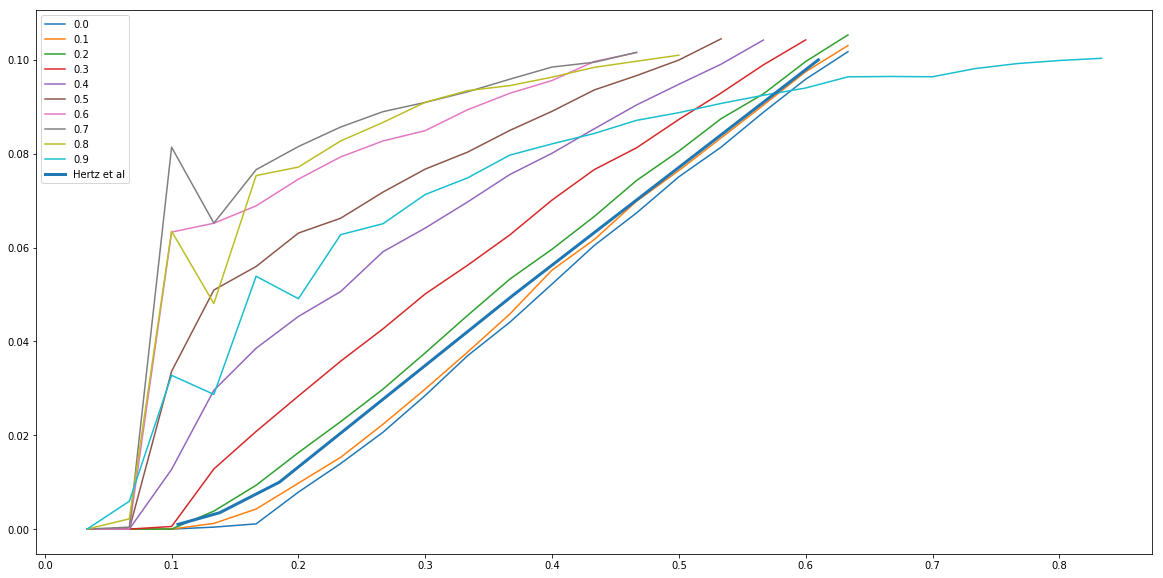

In [65]:
corrPlotCapacity(corrCapacity,tableHertzEtAl,30)

Se puede observar que para $\rho$ chicos la capacidad se ubica cerca de la teórica calculada por Herz. Pero conforme incrementa la correlación entre patrones, la capacidad cae hasta colapsar.

Es de notar que el método de generación de patrones correlacionados secuencialmente que se utilizó, donde se parte de una imagen A y se genra una imagen B con correlación $\rho$ con de A, y luego una imágen C con correlación $\rho$ con B implica que existe una correlación $\rho'< \rho$ entre A y C. Esa correlación no fue analizada en este trabajo.

## 3. Implemente una red de Hopfield ‘82 que aprenda patrones pseudo-aleatorios y estudie qué sucede con los patrones aprendidos cuando algunas interconexiones son eliminadas al azar.

In [43]:
def HoleFiller(W,proportional_step):
    holedW=np.copy(W)
    yield ( np.copy(holedW), 1 )
    
    shuffled_synapsis=np.random.permutation([ x for x in np.ndindex(* W.shape) if x[0]!=x[1] ])
    NCoord=len(shuffled_synapsis)
    step=np.floor(proportional_step * NCoord )
    i=1
    for coord in shuffled_synapsis:
        holedW[coord[0],coord[1]]=0
        if i%step == 0:
            yield ( np.copy(holedW), 1 - i/NCoord )
        i+=1
    
    if i%step!=1:
        yield ( np.copy(holedW), 1 - i/NCoord )
        

In [44]:
#testHoles
#list(HoleFiller(np.ones((10,10)),0.2))

In [45]:
def calcPWError(algo,imageGen,N,P,step):
    Images=imageGen(N,P)
    return [ (s, np.sum([(algo(image,W,N,1) != image ).astype(np.int32).sum()/N for image in Images ])/P )
                for W,s in HoleFiller(CalculateWeights(Images),step) ]

In [46]:
def repeatPErrorWithHoles(algo,imageGen,N,P,step):
    Error=calcPWError(algo,imageGen,N,P,step)
    s=[s for s,e in Error]
    acc=[ [e for s,e in Error], ]
    while(True):  
        acc+=[ [e for s,e in error] for error in [ calcPWError(algo,imageGen,N,P,step) for _ in range(10) ]]         
        std = np.std(acc,ddof=1,axis=0)
        if np.all(1.96*std/np.sqrt(len(acc)) < 0.01):
            break    
    return list(zip(itertools.repeat(P),s,np.mean(acc,axis=0)))

In [47]:
def holeCapacity(N):    
    P=1
    acc=[]
    PError = 0
    while PError < 0.1:
        print(N,P,PError,end='\r')
        result = repeatPErrorWithHoles(lambda a,b,c,d: syncHopfield(a,b,c,d,1),randImageGen, N, P,0.025)
        PError = np.min([x[-1] for x in result])
        acc+=result
        P+=1
    cleanLastPrintedLine()
    return pd.DataFrame(acc,columns=["P","Integrity","PError"]).set_index(["P","Integrity"])

### a) ¿Cómo cambia el error en función del porcentaje de sinapsis eliminadas?

In [71]:
integrityDf=holeCapacity(30)

In [72]:
def holePlot(df):
    for P, new_df in df.groupby("P"):
        ndf=new_df.reset_index()
        plt.plot(1-ndf["Integrity"],ndf["PError"],label=P)
        
    #ndf=tableHertzEtAl.reset_index()
    #plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)    
    plt.legend()
    plt.ylim([0,0.1])

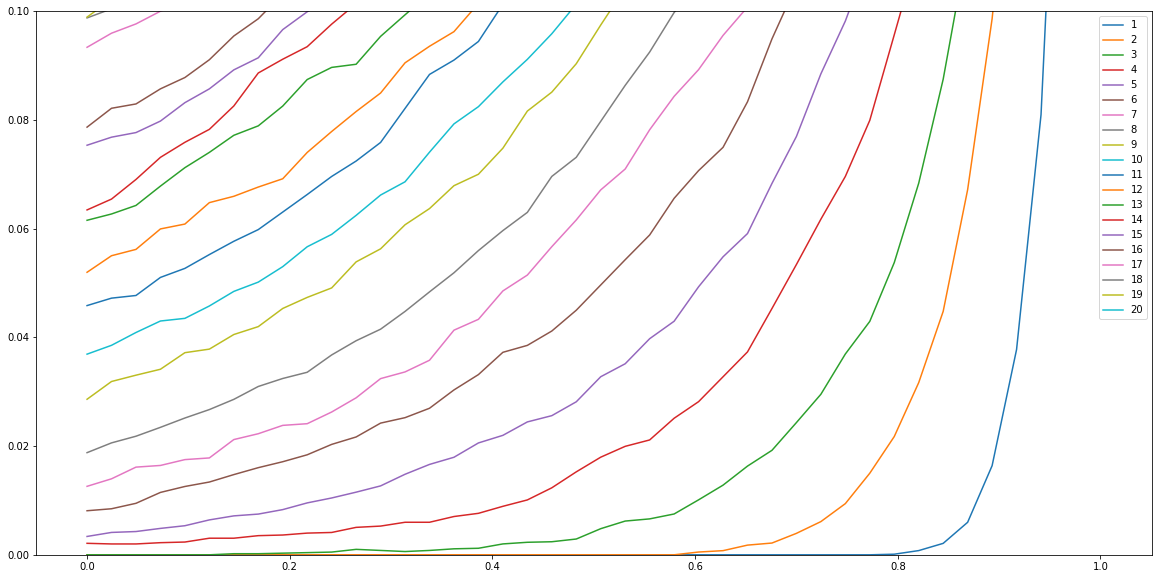

In [73]:
holePlot(integrityDf)
#ax.set_ylim([0, 0.1])

### b) ¿Cómo cambia la capacidad en función del porcentaje de sinapsis eliminadas?

In [48]:
def stepIterator(lst,step):
    i=0
    for x in lst:
        if i%step == 0:
            yield x
        i+=1
            

In [49]:
def holeCapacityPlot(df,tableHertzEtAl,N,skip):    
    for tg, new_df in stepIterator(reversed(tuple(df.groupby("Integrity"))),skip):
        ndf=new_df.reset_index()
        plt.plot(ndf["P"]/N,ndf["PError"],label="%.02f" % (1-tg))
        
    ndf=tableHertzEtAl.reset_index()
    plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)    
    plt.legend()
    plt.ylim([0,0.1])

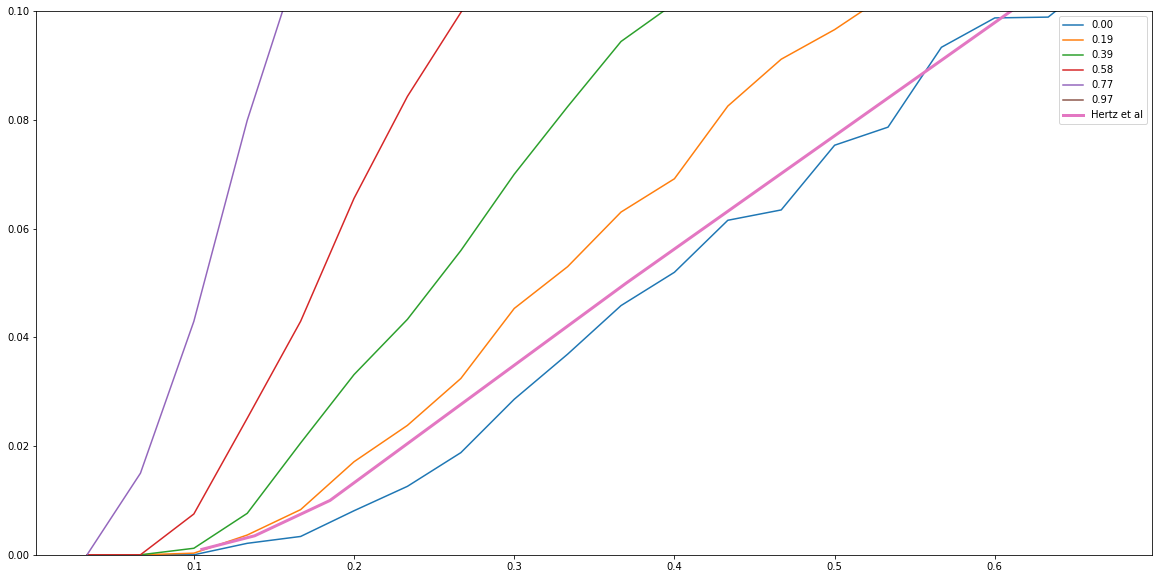

In [76]:
holeCapacityPlot(integrityDf,tableHertzEtAl,30,8)

## 4. Simular un modelo de Ising en una y dos dimensiones. Encontrar la temperatura crítica para ambos casos

Se utiliza el algoritmo de metrópolis para simular un modelo de Ising.
Se considera la simplificación que la interacción de intercambio magnético, vale 1 para los dipolos que estan en contacto en la red, y 0 para el resto.

In [61]:
def isValidCoord(coord, shape):
    return np.all(coord >= 0) & np.all(coord < shape)

In [62]:
#def squareKernel(N):
#    if N % 2 == 0:
#        raise Exception("Only Odd Sizes Allowed")
#    center=int(np.floor(N/2))
#    base=np.zeros((N,N))
#    base[center,center]=1
#    return [ tuple(x - np.array((center,center))) for x,y in np.ndenumerate(base) if y == 0]

In [63]:
def neighbours(coord, shape):
    kernel = [(0,1),(0,-1),(1,0),(-1,0)] # squareKernel(5)
    for mask in kernel:    
        neighbour_coord = np.add(coord,mask)
        if isValidCoord(neighbour_coord,shape):
            yield tuple(neighbour_coord)

In [64]:
def isingWeights(lattice):
    flat_indices=np.arange(lattice.size).reshape(lattice.shape)
    W=np.zeros((lattice.size,lattice.size))

    for coord,row in np.ndenumerate(flat_indices):
        for neighbour in neighbours(coord,flat_indices.shape):        
            W[row,flat_indices[neighbour]]=1
    return W

In [65]:
def rand2dImageGen(dim):
    return (np.random.rand(*dim) > 0.5).astype(np.int32).astype(np.double) * 2 - 1

In [66]:
def hasCurieTemp(lattice):
    #Todos los elementos son 1 o -1  
    #print( "Corto", np.abs(lattice.sum()), lattice.size)
    return np.abs(lattice.sum()) == lattice.size
    

Calculamos la energía de ising como: 

$H= -\frac{1}{2}\sum_{ij} w_{ij} \sigma_j \sigma_i + \frac{1}{2} \sum_{ij} w_{ij}$

El segundo término corresponde al mínimo de energía, cuando todos los spin están alineados y es una corrección para que la energía sea positiva.

In [67]:
def Energy(lattice,w):    
    lattice=lattice.reshape(-1,1)
    energy_offset=0.5 * np.sum(w) # Sumo la cantidad de aristas
    return -0.5*lattice.transpose().dot(w).dot(lattice).item() + energy_offset

Como criterio de aceptacion 

In [93]:
def isChangeAccepted(delta_E,T):        
    k=0.0008240694685686903
    if delta_E <= 0:
        return True    
    isAccepted = np.random.rand() < np.exp(-delta_E/k/T)   
    return isAccepted
    

Consideramos que se estabilizó en una temperatura, cuando podemos determinar la media de energía con 1% de error y un 95% de confianza.

In [111]:
def energyIsStable(old_Energies):
        break_condition = 1.96 * np.std(old_Energies,ddof=1)/np.sqrt(len(old_Energies))
        target = np.mean(old_Energies)*.01
        print("Will Stop if: %1.03f < %1.03f" % (break_condition,target),end="\r")
        if np.isnan(break_condition):
            print(old_Energies)
            print("Desvio", np.std(old_Energies,ddof=1))
            raise Exception("nan")
        return break_condition < target
    

In [121]:
def formatSpins(lattice):        
    return "\n".join( [ "".join(["\u2B06" if x > 0 else "\u2B07" for x in row ]) for row in lattice])

In [127]:
def plotSpins(lattice):
        plt.imshow(lattice)
        plt.axis('off')
        plt.show()

In [132]:
def metropolis(seed,w,T):
    original_shape=seed.shape
    outVal = np.copy(seed).reshape(-1,1)    
    iteration = 1;
    results = []
    old_Energies = [ Energy(outVal,W), ]
    print("%.03f" % T)
    print(formatSpins(outVal.reshape(original_shape)))
    
    while not hasCurieTemp(outVal):
        while True:
            prev_E=old_Energies[-1]            
            for _ in range(1):
                for i in np.random.permutation(len(outVal)):
                    #old_hi = outVal[i]                    
                    outVal[i]*=-1
                    new_E = Energy(outVal,W)
                    
                    if isChangeAccepted(new_E-prev_E,T):            
                        prev_E=new_E
                    else:
                        outVal[i]*=-1 #rollback
                                        
                old_Energies.append(prev_E)
                
            if hasCurieTemp(outVal) | energyIsStable(old_Energies):                
                break
                
        cleanLastPrintedLine()
        print("Temperature {:.2e}, Mean Energy {:.2e}".format(T,old_Energies[-1]))
        plotSpins(outVal.reshape(original_shape))
        #print(formatSpins(outVal.reshape(original_shape)))
        results.append((T, np.mean(old_Energies)))
        old_Energies = [ old_Energies[-1] ]
        T*= 0.9
    
    return results
    

100000000.000
⬆⬆⬇⬇⬇⬇⬆⬆⬆⬇⬆⬇⬆⬇⬆⬇⬇⬆⬇⬇⬆⬇⬆⬆⬇⬆⬇⬇⬆⬇⬇⬆⬆⬇⬆⬆⬆⬇⬆⬇⬇⬇⬇⬇⬇⬆⬇⬆⬇⬇⬆⬇⬇⬆⬆⬇⬇⬆⬆⬆⬇⬆⬇⬆⬆⬇⬆⬇⬆⬇⬆⬆⬇⬇⬇⬇⬇⬆⬇⬆
Temperature 1.00e+08, Mean Energy 9.60e+01


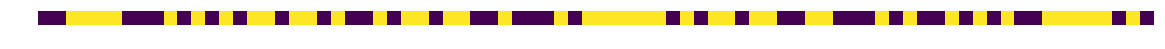

Temperature 9.00e+07, Mean Energy 9.60e+01


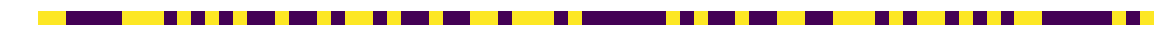

Temperature 8.10e+07, Mean Energy 9.60e+01


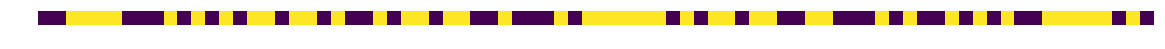

Temperature 7.29e+07, Mean Energy 9.60e+01


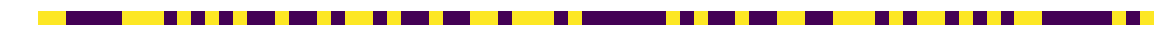

Temperature 6.56e+07, Mean Energy 9.60e+01


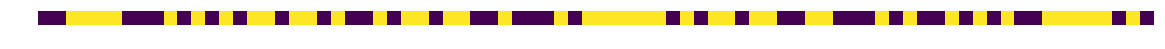

Temperature 5.90e+07, Mean Energy 9.60e+01


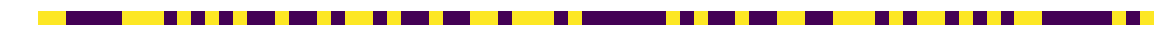

Temperature 5.31e+07, Mean Energy 9.60e+01


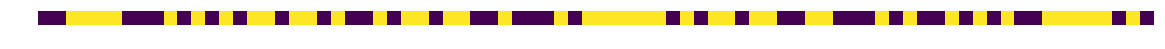

Temperature 4.78e+07, Mean Energy 9.60e+01


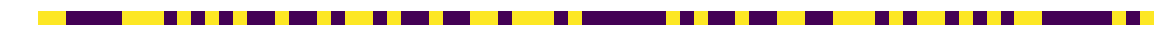

Temperature 4.30e+07, Mean Energy 9.60e+01


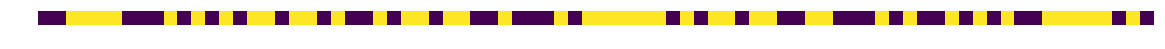

Temperature 3.87e+07, Mean Energy 9.60e+01


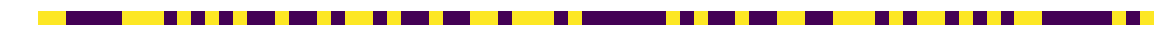

Temperature 3.49e+07, Mean Energy 9.60e+01


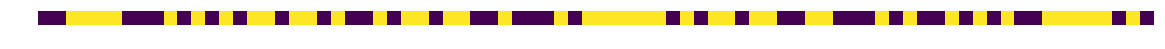

Temperature 3.14e+07, Mean Energy 9.60e+01


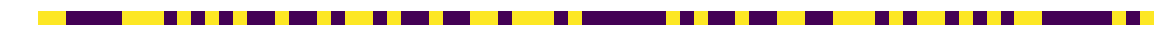

Temperature 2.82e+07, Mean Energy 9.60e+01


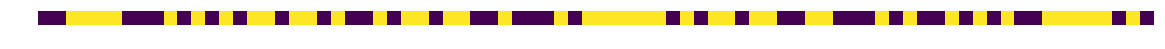

Temperature 2.54e+07, Mean Energy 9.60e+01


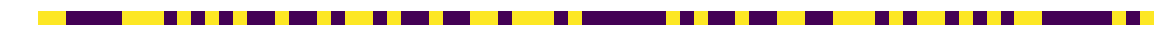

Temperature 2.29e+07, Mean Energy 9.60e+01


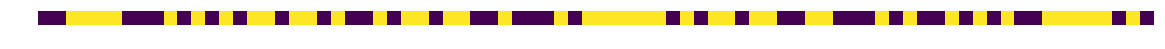

Temperature 2.06e+07, Mean Energy 9.60e+01


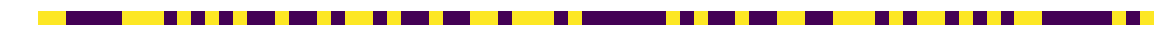

Temperature 1.85e+07, Mean Energy 9.60e+01


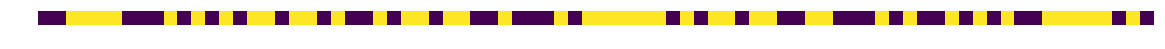

Temperature 1.67e+07, Mean Energy 9.60e+01


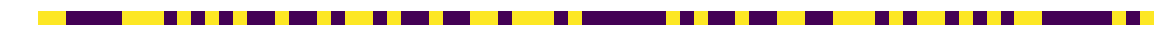

Temperature 1.50e+07, Mean Energy 9.60e+01


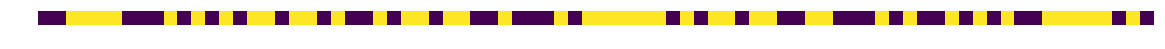

Temperature 1.35e+07, Mean Energy 9.60e+01


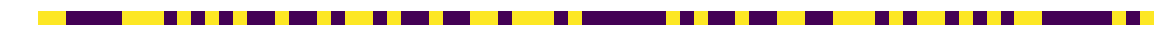

Temperature 1.22e+07, Mean Energy 9.60e+01


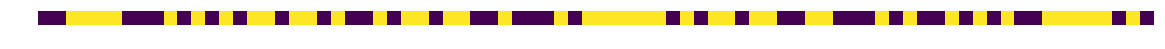

Temperature 1.09e+07, Mean Energy 9.60e+01


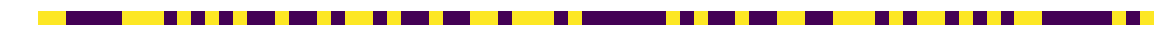

Temperature 9.85e+06, Mean Energy 9.60e+01


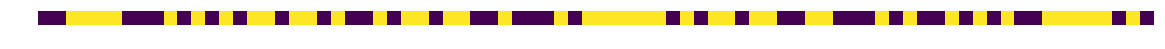

Temperature 8.86e+06, Mean Energy 9.60e+01


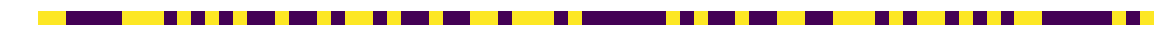

Temperature 7.98e+06, Mean Energy 9.60e+01


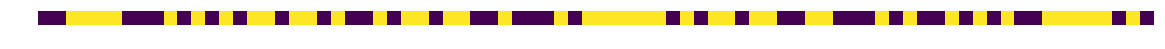

Temperature 7.18e+06, Mean Energy 9.60e+01


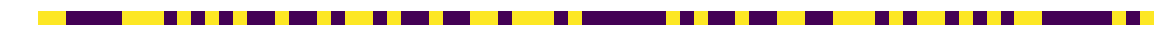

Temperature 6.46e+06, Mean Energy 9.60e+01


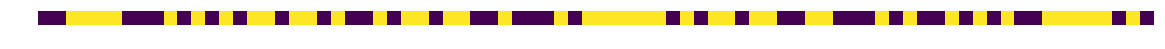

Temperature 5.81e+06, Mean Energy 9.60e+01


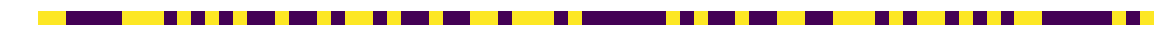

Temperature 5.23e+06, Mean Energy 9.60e+01


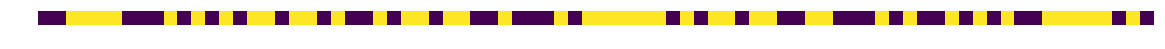

Temperature 4.71e+06, Mean Energy 9.60e+01


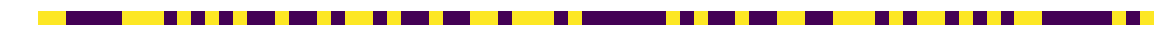

Temperature 4.24e+06, Mean Energy 9.60e+01


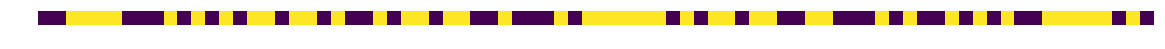

Temperature 3.82e+06, Mean Energy 9.60e+01


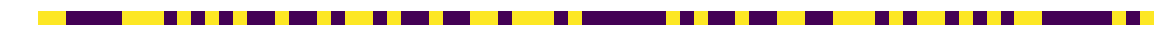

Temperature 3.43e+06, Mean Energy 9.60e+01


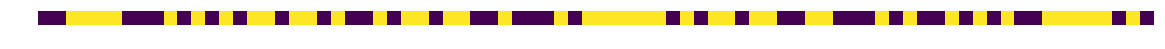

Temperature 3.09e+06, Mean Energy 9.60e+01


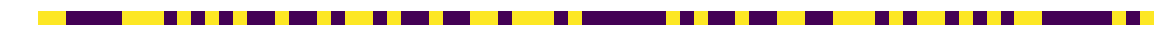

Temperature 2.78e+06, Mean Energy 9.60e+01


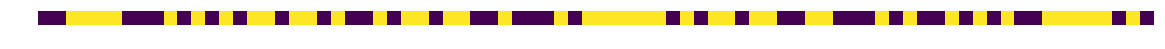

Temperature 2.50e+06, Mean Energy 9.60e+01


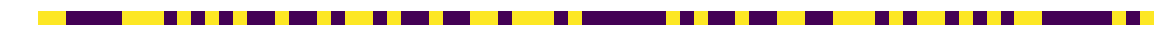

Temperature 2.25e+06, Mean Energy 9.60e+01


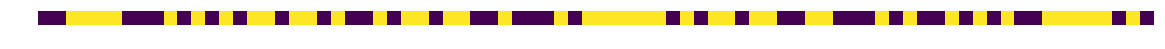

Temperature 2.03e+06, Mean Energy 9.60e+01


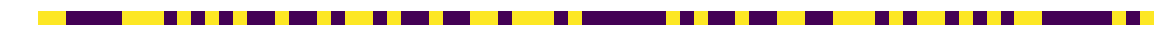

Temperature 1.82e+06, Mean Energy 9.60e+01


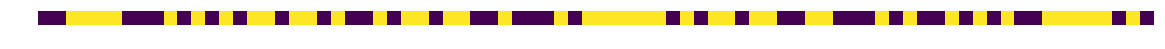

Temperature 1.64e+06, Mean Energy 9.60e+01


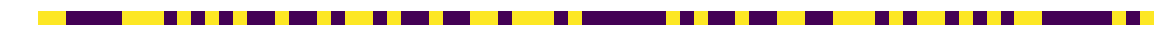

Temperature 1.48e+06, Mean Energy 8.80e+01


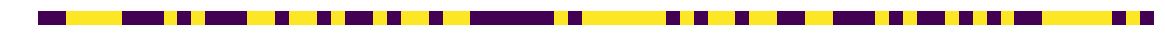

Temperature 1.33e+06, Mean Energy 8.80e+01


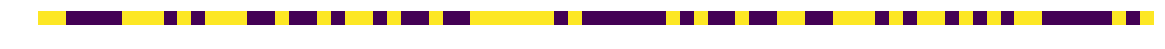

Temperature 1.20e+06, Mean Energy 8.80e+01


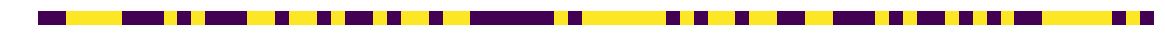

Temperature 1.08e+06, Mean Energy 8.80e+01


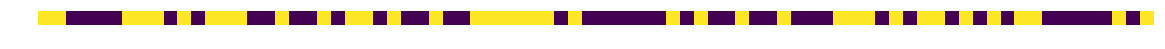

Temperature 9.70e+05, Mean Energy 8.80e+01


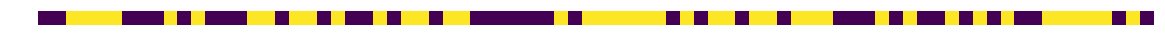

Temperature 8.73e+05, Mean Energy 8.80e+01


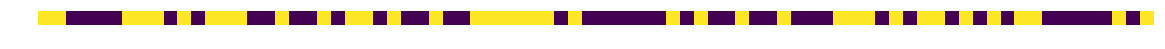

Temperature 7.86e+05, Mean Energy 8.80e+01


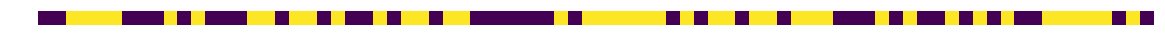

Temperature 7.07e+05, Mean Energy 8.40e+01


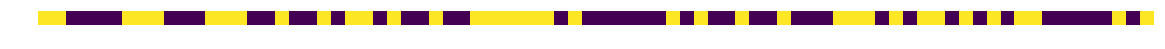

Temperature 6.36e+05, Mean Energy 8.40e+01


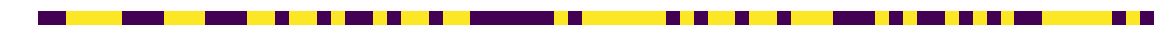

Temperature 5.73e+05, Mean Energy 8.40e+01


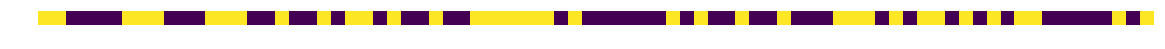

Temperature 5.15e+05, Mean Energy 7.80e+01                                      


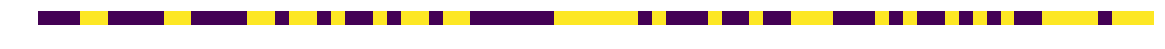

Temperature 4.64e+05, Mean Energy 7.80e+01


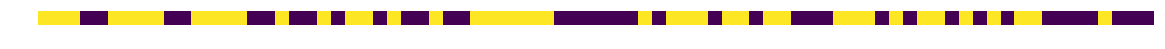

Temperature 4.17e+05, Mean Energy 7.80e+01


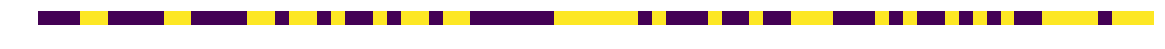

Temperature 3.76e+05, Mean Energy 7.00e+01                                      


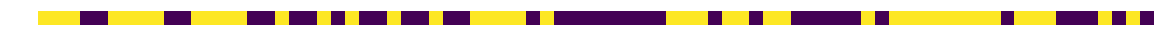

Temperature 3.38e+05, Mean Energy 7.00e+01


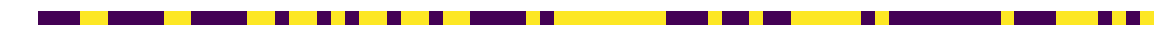

Temperature 3.04e+05, Mean Energy 7.00e+01


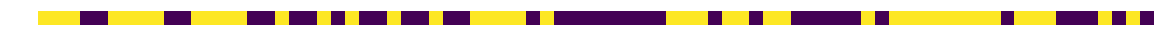

Temperature 2.74e+05, Mean Energy 7.40e+01


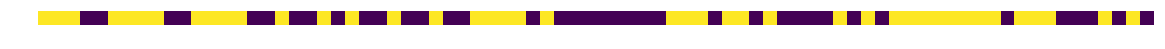

Temperature 2.47e+05, Mean Energy 7.40e+01


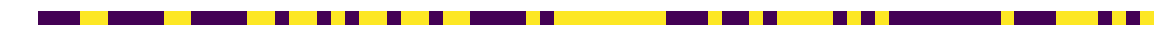

Temperature 2.22e+05, Mean Energy 7.40e+01


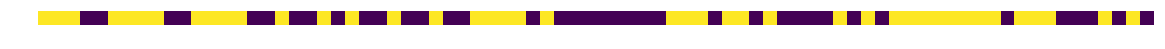

Temperature 2.00e+05, Mean Energy 7.40e+01                                      


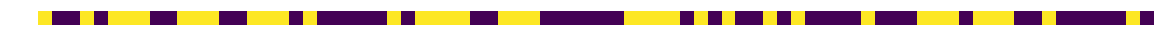

Temperature 1.80e+05, Mean Energy 7.40e+01


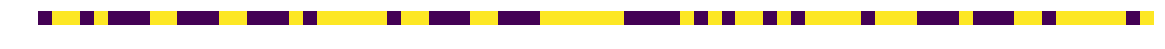

Temperature 1.62e+05, Mean Energy 7.40e+01


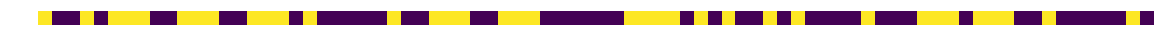

Temperature 1.46e+05, Mean Energy 7.40e+01


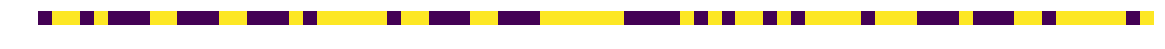

Temperature 1.31e+05, Mean Energy 7.40e+01


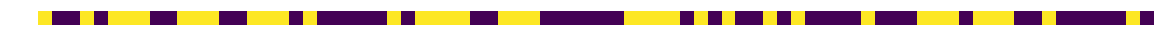

Temperature 1.18e+05, Mean Energy 8.40e+01                                      


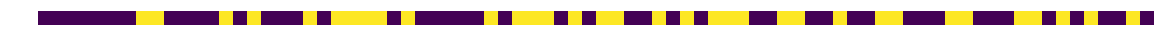

Temperature 1.06e+05, Mean Energy 8.60e+01                                      


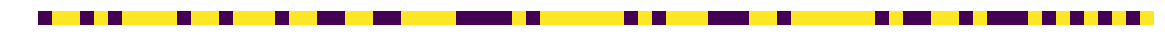

Temperature 9.55e+04, Mean Energy 8.60e+01


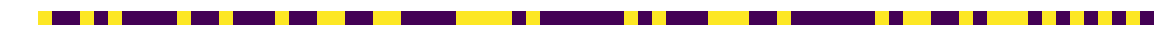

Temperature 8.60e+04, Mean Energy 8.60e+01


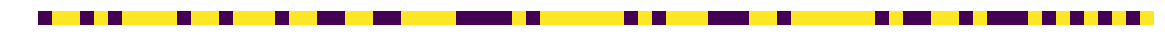

Temperature 7.74e+04, Mean Energy 7.60e+01                                      


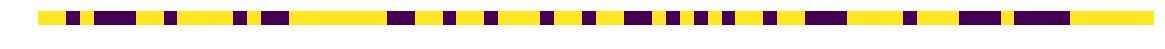

Temperature 6.96e+04, Mean Energy 7.60e+01


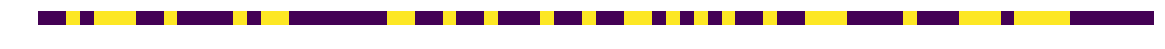

Temperature 6.27e+04, Mean Energy 7.60e+01


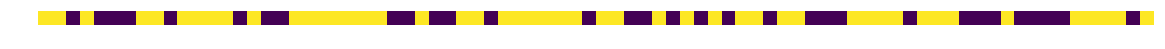

Temperature 5.64e+04, Mean Energy 6.60e+01                                      


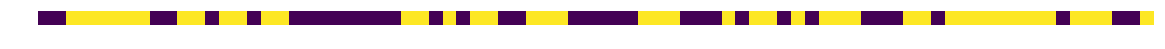

Temperature 5.08e+04, Mean Energy 8.40e+01                                      


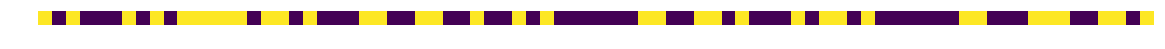

Temperature 4.57e+04, Mean Energy 8.40e+01


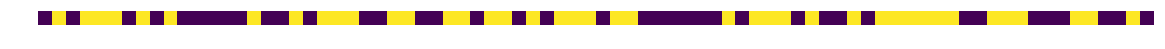

Temperature 4.11e+04, Mean Energy 8.40e+01


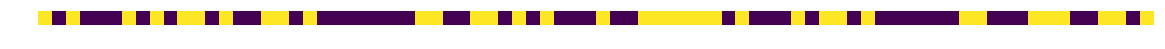

Temperature 3.70e+04, Mean Energy 7.20e+01                                      


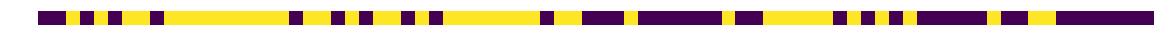

Temperature 3.33e+04, Mean Energy 8.20e+01                                      


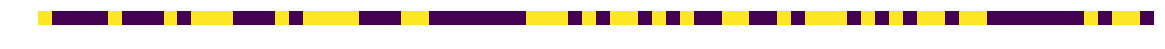

Temperature 3.00e+04, Mean Energy 7.60e+01                                      


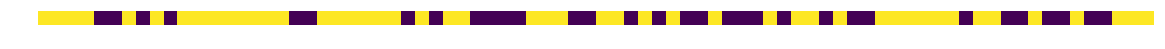

Temperature 2.70e+04, Mean Energy 7.60e+01


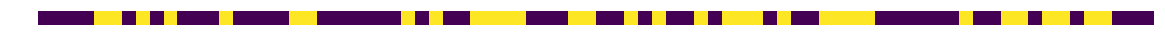

Temperature 2.43e+04, Mean Energy 7.40e+01                                      


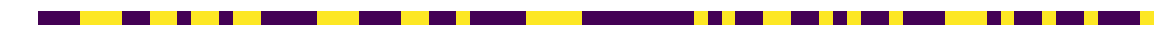

Temperature 2.18e+04, Mean Energy 7.40e+01


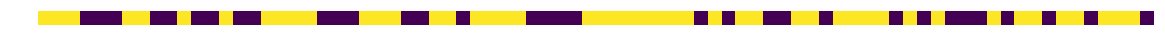

Temperature 1.97e+04, Mean Energy 6.80e+01                                      


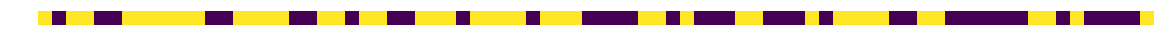

Temperature 1.77e+04, Mean Energy 7.40e+01                                      


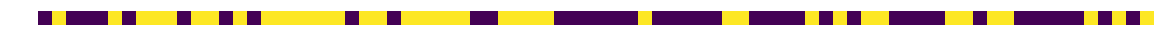

Temperature 1.59e+04, Mean Energy 7.40e+01


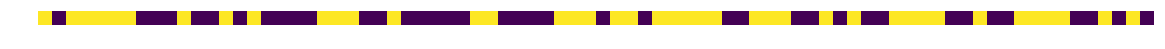

Temperature 1.43e+04, Mean Energy 7.00e+01                                      


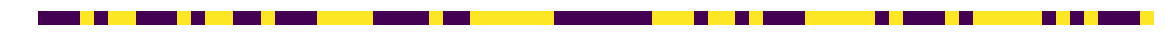

Temperature 1.29e+04, Mean Energy 6.80e+01                                      


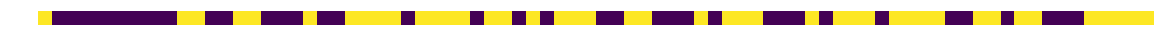

Temperature 1.16e+04, Mean Energy 6.80e+01


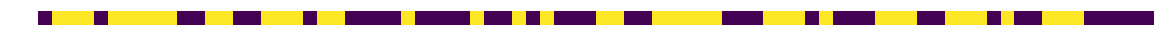

Temperature 1.04e+04, Mean Energy 6.60e+01                                      


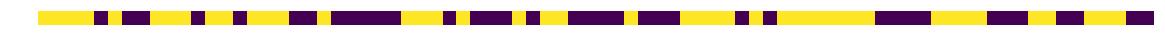

Temperature 9.40e+03, Mean Energy 6.40e+01                                      


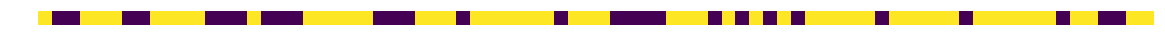

Temperature 8.46e+03, Mean Energy 6.60e+01                                      


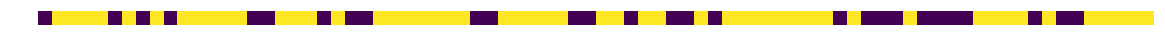

Temperature 7.62e+03, Mean Energy 6.80e+01                                      


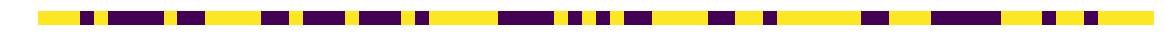

Temperature 6.86e+03, Mean Energy 7.00e+01                                      


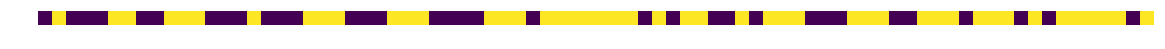

Temperature 6.17e+03, Mean Energy 6.80e+01                                      


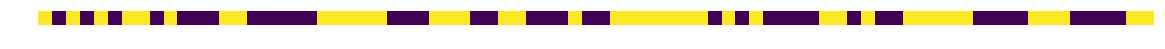

Temperature 5.55e+03, Mean Energy 6.00e+01                                      


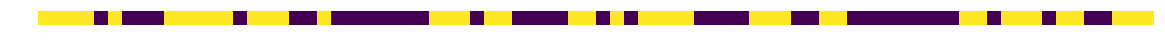

Temperature 5.00e+03, Mean Energy 6.00e+01                                      


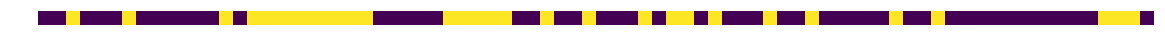

Temperature 4.50e+03, Mean Energy 5.60e+01                                      


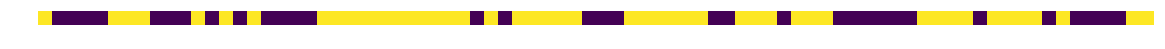

Temperature 4.05e+03, Mean Energy 4.80e+01                                      


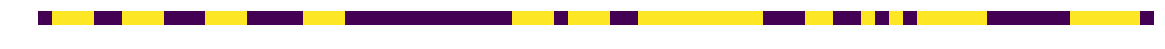

Temperature 3.64e+03, Mean Energy 5.60e+01                                      


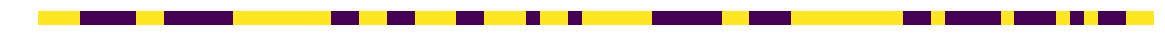

Temperature 3.28e+03, Mean Energy 5.60e+01                                      


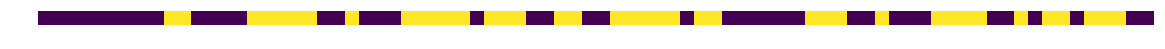

Temperature 2.95e+03, Mean Energy 4.20e+01                                      


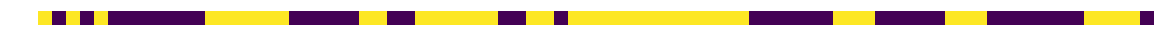

Temperature 2.66e+03, Mean Energy 5.20e+01                                      


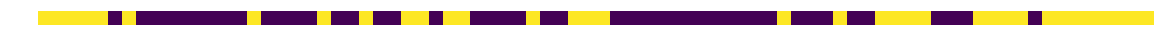

Temperature 2.39e+03, Mean Energy 4.80e+01                                      


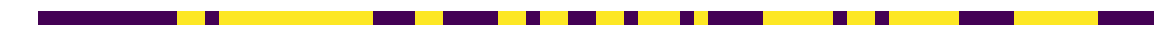

Temperature 2.15e+03, Mean Energy 4.40e+01                                      


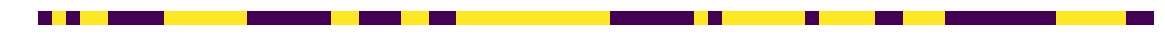

Temperature 1.94e+03, Mean Energy 4.40e+01


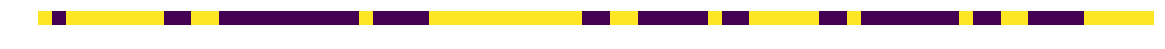

Temperature 1.74e+03, Mean Energy 4.00e+01                                      


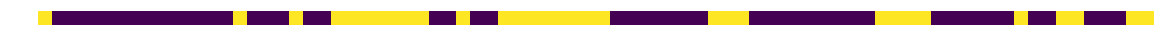

Temperature 1.57e+03, Mean Energy 2.40e+01                                      


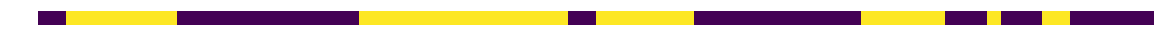

Temperature 1.41e+03, Mean Energy 2.60e+01                                      


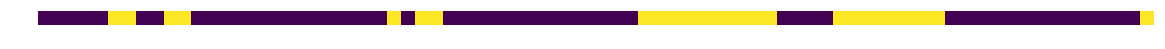

Temperature 1.27e+03, Mean Energy 2.40e+01                                      


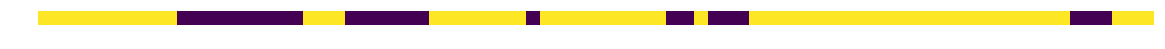

Temperature 1.14e+03, Mean Energy 1.60e+01                                      


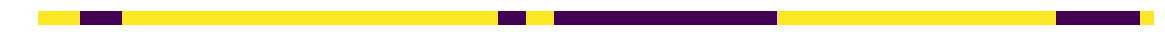

Temperature 1.03e+03, Mean Energy 0.00e+00


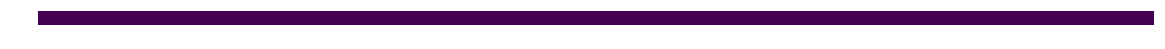

(1029.0430145553223, 10.947368421052632)

In [133]:
lattice=rand2dImageGen((1,80))
W=isingWeights(lattice)
result=metropolis(lattice,W,1E8)
result[-1]

10000.000
⬆⬇⬇⬆⬇⬇⬇⬆⬇⬇⬇⬆⬇⬆⬇⬆⬇⬇⬆⬆⬇⬆⬇⬇⬆⬇⬆⬇⬇⬆⬆⬆⬆⬇⬆⬆⬇⬇⬇⬆⬆⬆⬇⬆⬇⬆⬇⬆⬆⬇⬆⬇⬆⬆⬇⬇⬇⬆⬆⬆
⬆⬆⬆⬆⬇⬇⬆⬆⬆⬆⬇⬇⬆⬆⬇⬇⬇⬇⬇⬆⬆⬆⬆⬆⬇⬆⬆⬇⬆⬇⬇⬇⬇⬆⬇⬆⬆⬆⬇⬆⬆⬆⬆⬇⬆⬇⬆⬆⬆⬇⬆⬇⬆⬆⬆⬆⬆⬇⬇⬇
⬇⬇⬆⬆⬆⬇⬇⬇⬆⬇⬇⬇⬆⬆⬆⬇⬇⬆⬆⬆⬆⬆⬇⬆⬇⬆⬇⬇⬇⬇⬇⬆⬆⬇⬆⬇⬇⬆⬇⬇⬆⬆⬆⬆⬇⬆⬆⬇⬇⬆⬆⬇⬇⬇⬇⬆⬆⬆⬆⬆
⬇⬇⬆⬇⬆⬇⬇⬆⬇⬇⬆⬆⬆⬇⬆⬆⬆⬇⬇⬆⬆⬇⬇⬆⬇⬆⬆⬆⬆⬆⬆⬇⬆⬇⬇⬇⬆⬆⬇⬇⬆⬆⬆⬆⬆⬇⬆⬆⬇⬆⬇⬇⬆⬇⬆⬆⬇⬇⬇⬆
⬆⬇⬆⬇⬇⬆⬆⬇⬆⬇⬇⬆⬇⬆⬇⬇⬆⬆⬆⬆⬇⬇⬇⬇⬇⬆⬇⬇⬇⬇⬇⬆⬆⬆⬇⬆⬇⬆⬇⬆⬆⬇⬆⬇⬆⬇⬆⬆⬇⬆⬆⬆⬇⬆⬆⬇⬇⬇⬆⬆
⬇⬆⬆⬇⬆⬆⬇⬇⬆⬆⬇⬇⬆⬆⬆⬇⬇⬇⬇⬇⬇⬆⬆⬇⬆⬇⬇⬇⬇⬆⬆⬆⬆⬇⬆⬇⬇⬇⬇⬇⬆⬆⬆⬇⬇⬇⬆⬆⬇⬇⬆⬆⬇⬆⬆⬆⬇⬆⬇⬇
⬇⬇⬆⬆⬆⬇⬆⬇⬇⬇⬇⬇⬆⬇⬆⬇⬆⬆⬆⬆⬇⬇⬇⬇⬇⬇⬆⬇⬆⬇⬇⬆⬇⬇⬇⬆⬇⬆⬆⬇⬇⬇⬇⬇⬇⬇⬆⬆⬆⬇⬇⬇⬆⬇⬇⬆⬆⬇⬇⬆
⬆⬆⬆⬇⬇⬇⬆⬇⬆⬇⬆⬇⬇⬆⬆⬇⬇⬆⬇⬆⬇⬆⬇⬇⬆⬆⬆⬆⬇⬆⬇⬇⬆⬇⬇⬆⬆⬆⬇⬆⬆⬆⬇⬇⬇⬆⬆⬇⬆⬆⬆⬇⬇⬆⬆⬆⬆⬆⬆⬇
⬇⬇⬆⬇⬆⬆⬇⬇⬆⬇⬇⬆⬆⬆⬆⬇⬇⬇⬇⬇⬆⬆⬇⬇⬇⬇⬇⬇⬇⬆⬇⬆⬆⬇⬇⬆⬆⬇⬇⬆⬇⬇⬇⬇⬇⬆⬆⬆⬆⬆⬆⬆⬇⬇⬆⬆⬆⬇⬆⬇
⬇⬇⬇⬆⬆⬇⬆⬆⬆⬇⬇⬆⬆⬇⬇⬆⬆⬇⬆⬆⬆⬇⬇⬆⬆⬆⬆⬆⬇⬇⬆⬇⬇⬆⬆⬇⬆⬆⬇⬇⬇⬆⬆⬆⬇⬇⬆⬆⬇⬆⬇⬇⬆⬇⬆⬇⬇⬇⬆⬇
Temperature 1.00e+04, Mean Energy 9.92e+02                                      


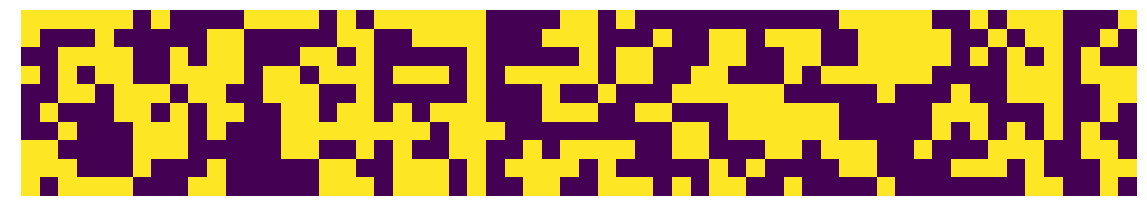

Temperature 9.00e+03, Mean Energy 9.84e+02                                      


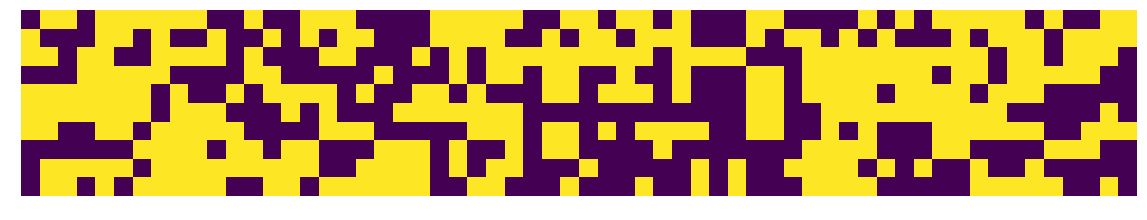

Temperature 8.10e+03, Mean Energy 9.42e+02                                      


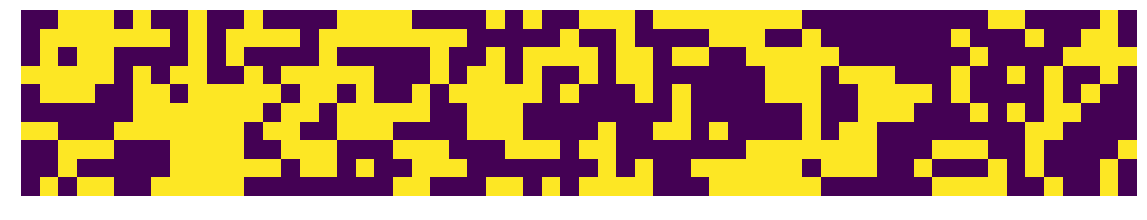

Temperature 7.29e+03, Mean Energy 9.34e+02                                      


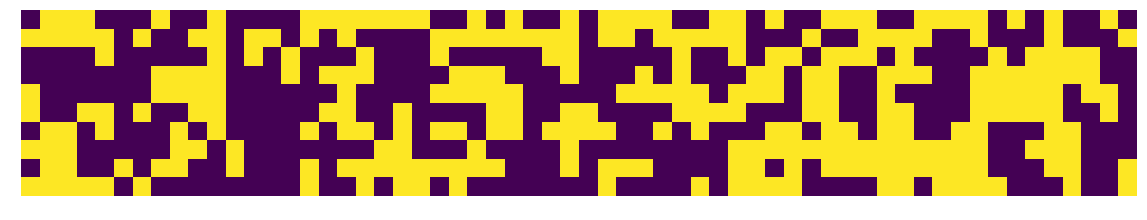

Temperature 6.56e+03, Mean Energy 9.18e+02                                      


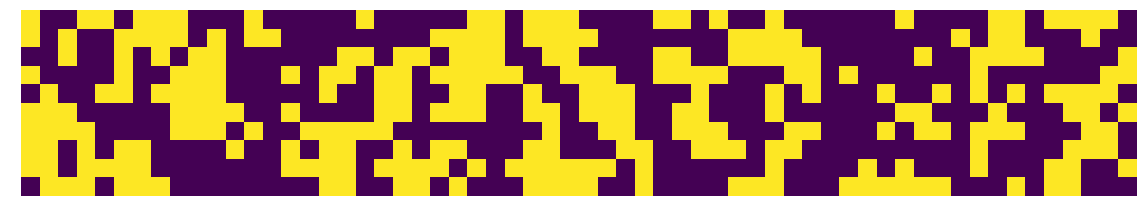

Temperature 5.90e+03, Mean Energy 8.74e+02                                      


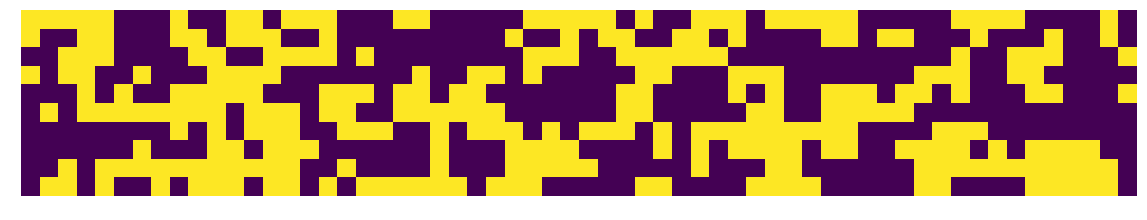

Temperature 5.31e+03, Mean Energy 8.48e+02                                      


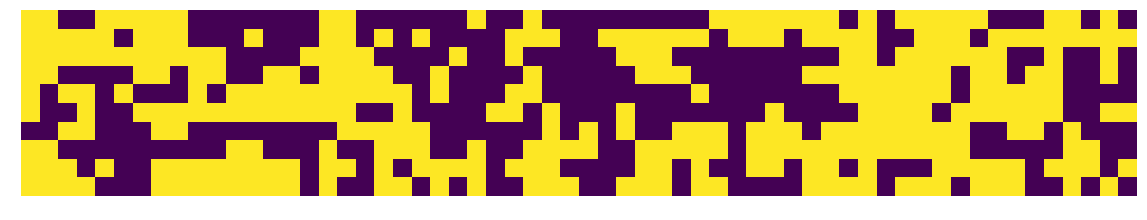

Temperature 4.78e+03, Mean Energy 8.06e+02                                      


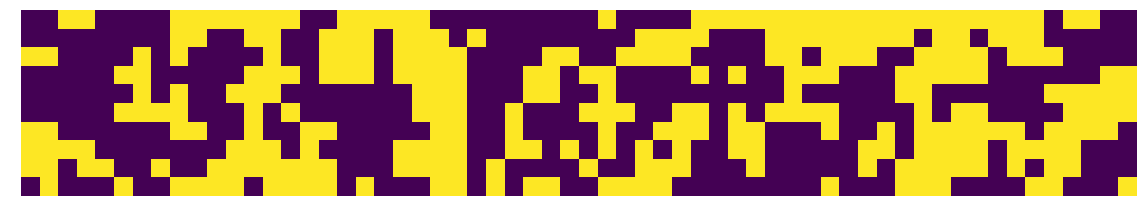

Temperature 4.30e+03, Mean Energy 7.38e+02                                      


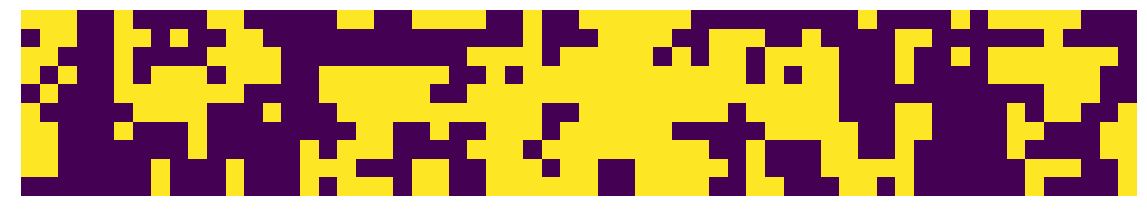

Temperature 3.87e+03, Mean Energy 7.04e+02                                      


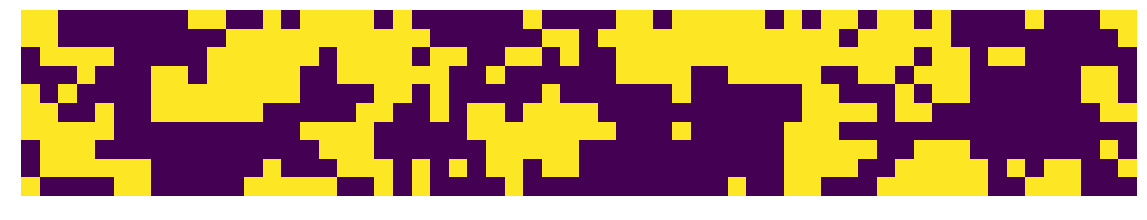

Temperature 3.49e+03, Mean Energy 6.62e+02                                      


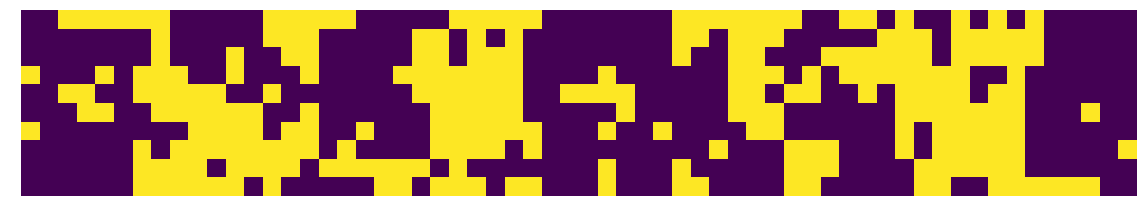

Temperature 3.14e+03, Mean Energy 5.20e+02                                      


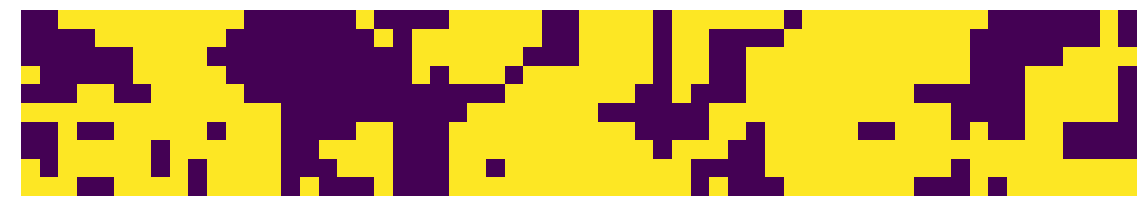

Temperature 2.82e+03, Mean Energy 4.54e+02                                      


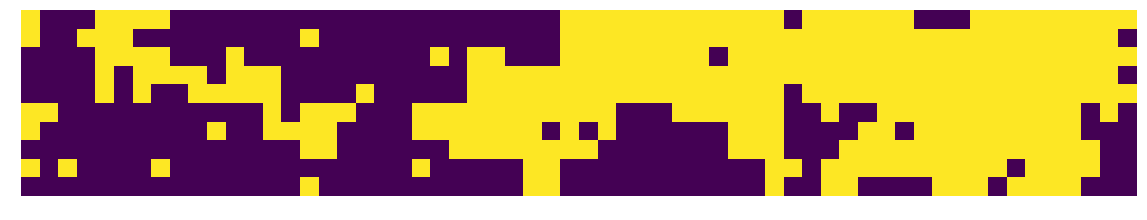

Temperature 2.54e+03, Mean Energy 3.26e+02                                      


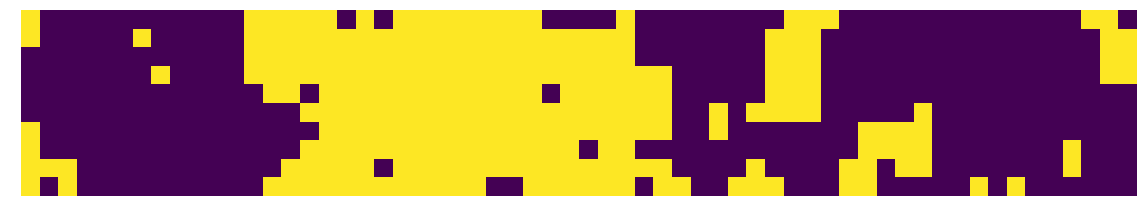

Temperature 2.29e+03, Mean Energy 2.16e+02                                      


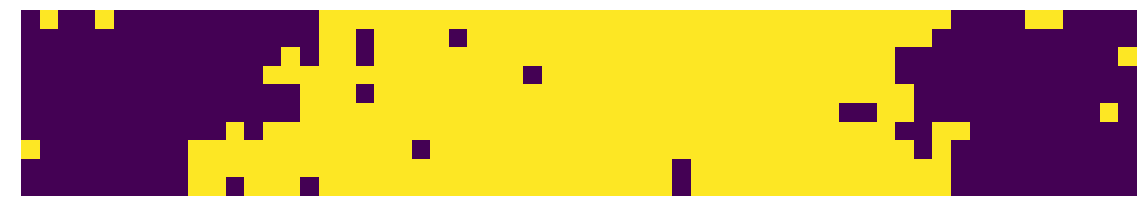

Temperature 2.06e+03, Mean Energy 1.36e+02                                      


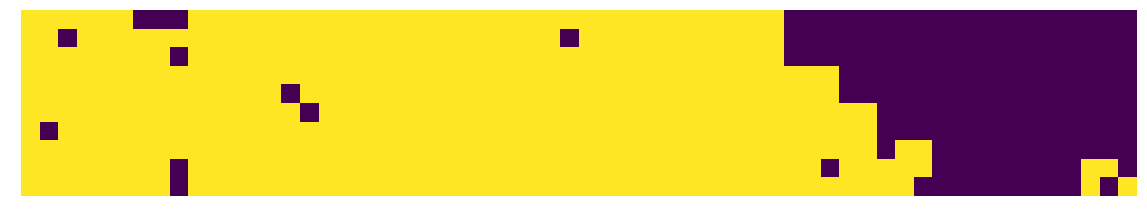

Temperature 1.85e+03, Mean Energy 0.00e+00                                      


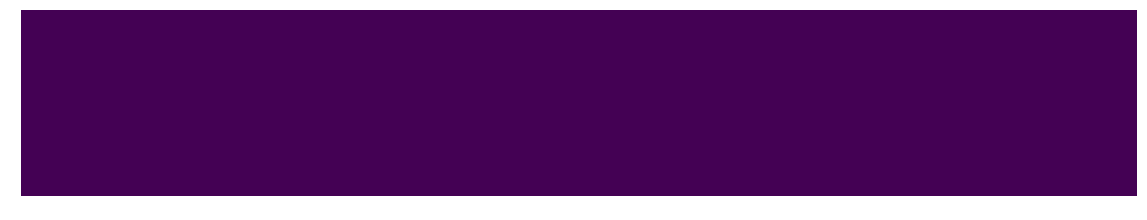

(1853.0201888518413, 58.44349497970519)

In [135]:
lattice=rand2dImageGen((10,60))
W=isingWeights(lattice)
result=metropolis(lattice,W,10000)
result[-1]

In [241]:
np.size([[1,2],[3,4]])

4

In [ ]:
np.exp(-1/1E-3)

In [ ]:
np.random.rand()

In [ ]:
base=np.zeros((5,5))
base[2,2]=1
[ x for x,y in np.ndenumerate(base) if y == 0]

In [ ]:
np.random.choice(10)np.random.